# Aug ??st, 2021 (play boot)

**Motivation**: SVINET <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.svinet import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Mice

In [2]:
svinet_props = {
    'task': 'rest',
    'mode': 'bold',
    'metric': 'pearson',
    'match_metric': 'cosine',
    'graph_type': 'real',
}
mice = Mice(Config(128))
mice.combine_dfs(svinet_props.get('task', 'rest'), full=True)

k = 7
p = 20
figs_dir = [
    mice.cfg.results_dir,
    'SVINET',
    'figs_combined',
    '-'.join([
        f"{svinet_props.get('graph_type', 'real')}",
        f"p{p}",
        f"k{k}",
    ]),
]
figs_dir = pjoin(*figs_dir)
os.makedirs(figs_dir, exist_ok=True)
print(figs_dir)

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k7

## Align loaded fits using svinet.gam

In [3]:
svinet = SVINET(mice, k, p, 'sub-SLC')
result = align_svinet_group(mice, k, p, global_order=False, **svinet_props)
list(result)

current expt: 'p20'

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


['perms', 'gam', 'pi', 'gamma_all', 'svinet_all']

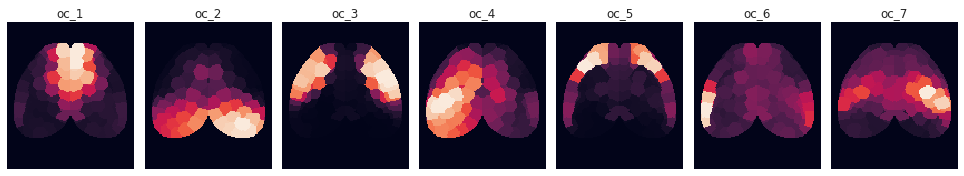

In [4]:
fig, axes = create_figure(1, k, (13.5, 4) if k == 7 else (12, 6))
gam_arr = svinet.pi2arr(result['pi'], cortex_only=True)
for ax, idx in zip(axes.ravel(), range(1, k + 1)):
    im = ax.imshow(gam_arr[idx], cmap='rocket', vmin=0)
    ax.set_title(f"oc_{idx}")
remove_ticks(axes)
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

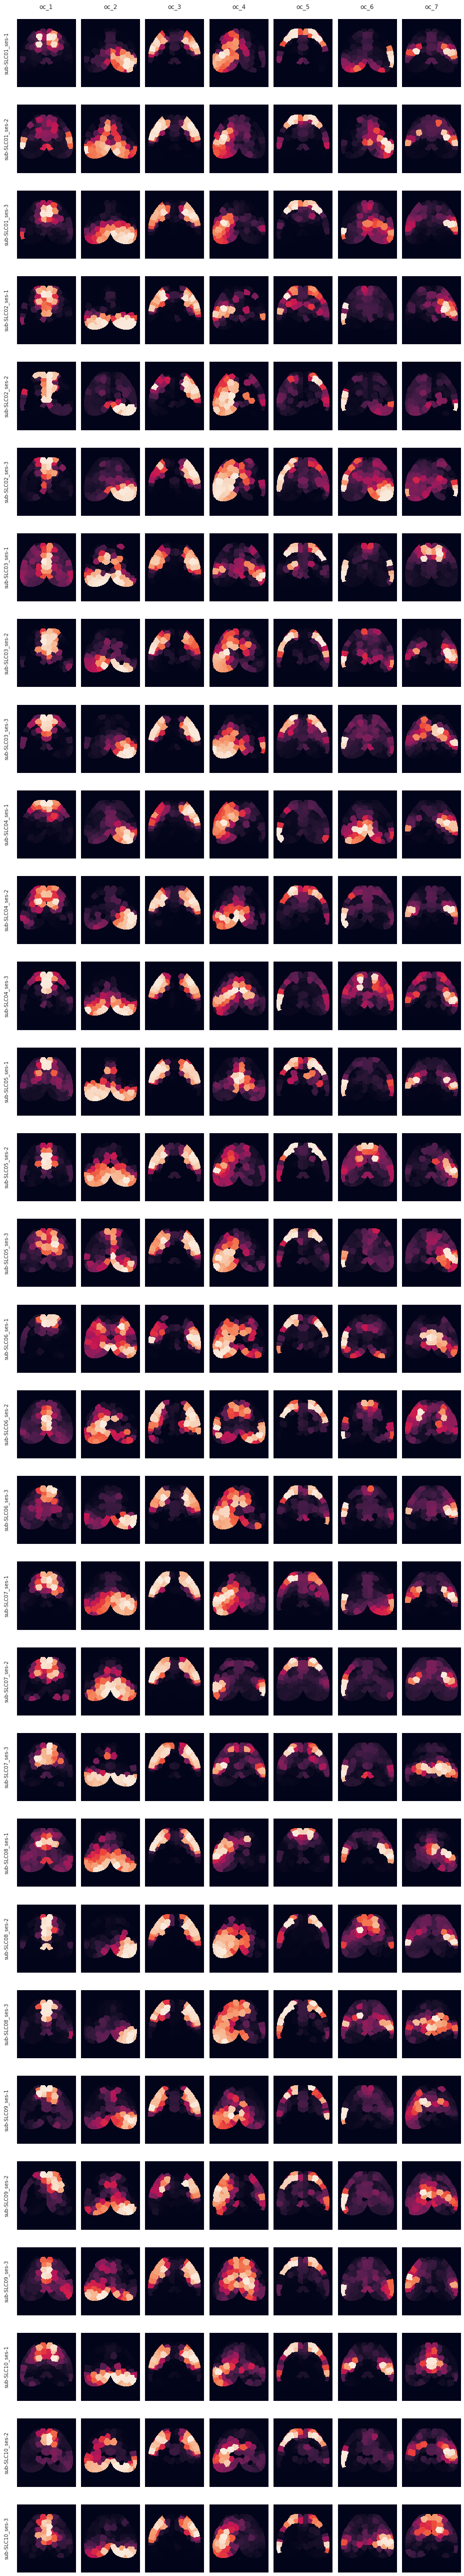

In [5]:
nrows = len(result['gamma_all'])
fig, axes = create_figure(nrows, k, (13, 2.4 * nrows))

for i, (key, gam) in tqdm(enumerate(result['gamma_all'].items()), total=nrows):
    gam_arr = svinet.pi2arr(gam, cortex_only=True)
    for j, idx in enumerate(range(1, k + 1)):
        im = axes[i, j].imshow(gam_arr[idx], cmap='rocket', vmin=0)
        # plt.colorbar(im, ax=axes[i, j], shrink=0.5)
        if i == 0:
            axes[i, j].set_title(f"oc_{idx}\n")
        if j == 0:
            axes[i, j].set_ylabel(f"{key}\n")
remove_ticks(axes)
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

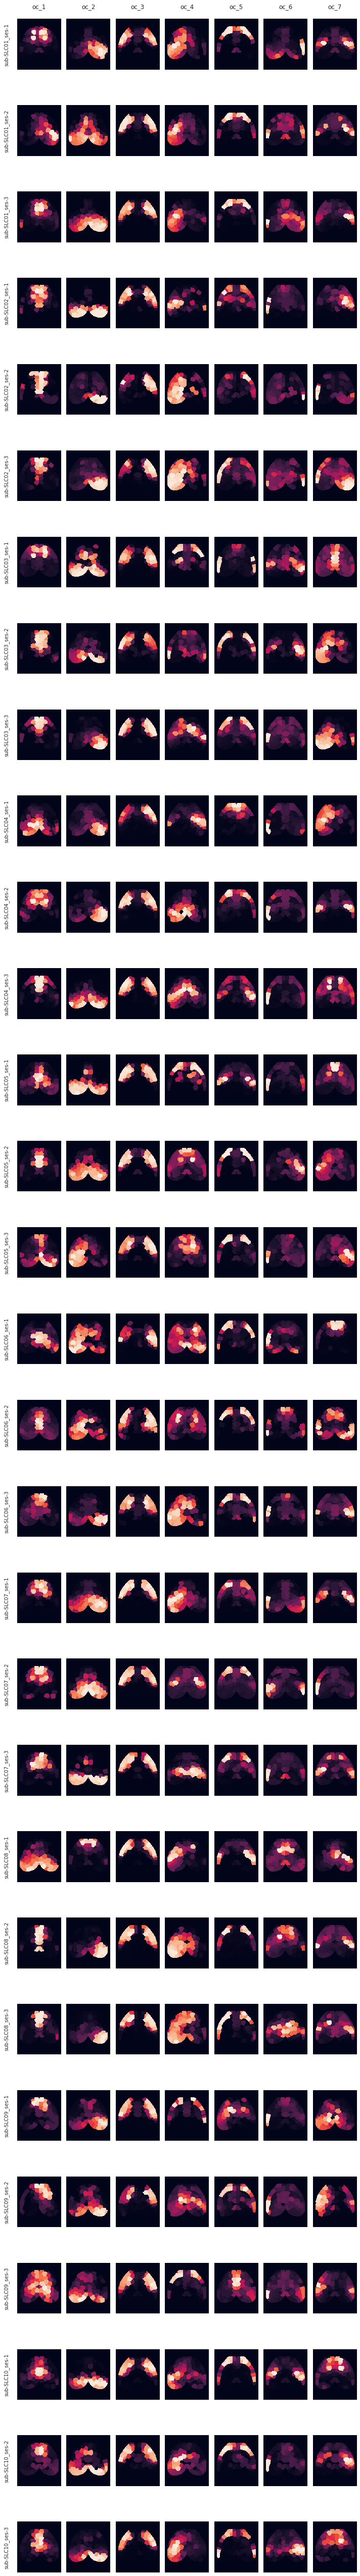

In [6]:
nrows = len(result['svinet_all'])
fig, axes = create_figure(nrows, k, (10, 2.4 * nrows))

for i, (key, sv) in tqdm(enumerate(result['svinet_all'].items()), total=nrows):
    gam_arr = svinet.pi2arr(sv.gam, cortex_only=True)
    for j, idx in enumerate(range(1, k + 1)):
        im = axes[i, j].imshow(gam_arr[idx], cmap='rocket', vmin=0)
        if i == 0:
            axes[i, j].set_title(f"oc_{idx}\n")
        if j == 0:
            axes[i, j].set_ylabel(f"{key}\n")
remove_ticks(axes)
plt.show()

In [7]:
fix_idx = np.concatenate([
    np.array(list(v.values())).reshape(1, -1)
    for v in result['perms'].values()
])
ctr = {}
for i in range(k):
    ctr[i] = collections.Counter(fix_idx[:, i]).most_common()
ctr

{
    0: [(0, 21), (6, 4), (5, 2), (4, 2), (3, 1)],
    1: [(1, 27), (0, 2), (3, 1)],
    2: [(2, 30)],
    3: [(3, 16), (6, 8), (5, 2), (0, 2), (1, 2)],
    4: [(4, 23), (3, 4), (5, 2), (1, 1)],
    5: [(5, 19), (6, 5), (0, 2), (4, 2), (3, 2)],
    6: [(6, 13), (3, 6), (5, 5), (0, 3), (4, 3)]
}

In [8]:
_norm = np.linalg.norm(sv.gam_all.reshape(len(sv.gam_all), -1), axis=-1)
collections.Counter(np.round(_norm, 5))

Counter({966.0: 1000})

In [9]:
np.linalg.norm(sv.gam.ravel())

792.9328455635766

<AxesSubplot:ylabel='Count'>

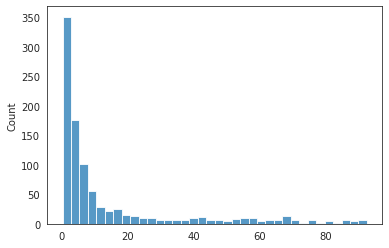

In [10]:
sns.histplot(np.round(sv.gam, 2).ravel())

In [5]:
def dir_var(a, axis=0):
    a0 = np.sum(a, axis=axis, keepdims=True)
    b = np.divide(a, a0)
    return np.divide(b * (1 - b), 1 + a0)

In [6]:
sv = list(result['svinet_all'].values())[0]
x = sv.gam_all.copy()
var = dir_var(x, axis=1)
var.shape

(1000, 5, 138)

In [7]:
list(result['svinet_all'])[0]

'sub-SLC01_ses-1'

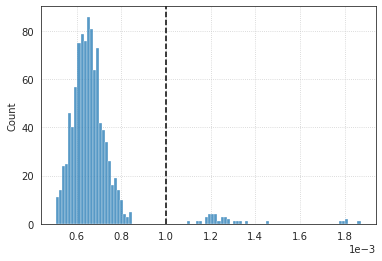

In [8]:
var_mean = np.nanmean(np.nanmean(var, axis=2), axis=1)
sns.histplot(var_mean, stat='count', bins=100)
plt.axvline(1.e-3, color='k', ls='--')
plt.ticklabel_format(axis='x', style='sci', scilimits=(1, 2))
plt.grid(ls=':')

In [9]:
bad_seeds = np.where(var_mean > 1.e-3)[0]

In [10]:
bad_seeds

array([  1,   2,  45,  52,  60, 213, 217, 225, 250, 259, 267, 306, 336,
       382, 387, 429, 459, 526, 547, 586, 589, 598, 602, 609, 622, 652,
       711, 712, 756, 773, 776, 825, 829, 832, 838, 946, 982])

In [7]:
sv = SVINET(mice, k, p, 'sub-SLC01_ses-1').load_results()

current expt: 'p20'

[PROGRESS] loading 'k12-real-cosine-linksampling-(2021_08_19)' from
'/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/b
old_pearson_task-rest_sub-SLC01_ses-1_n128/p20'

[PROGRESS] process results: done

[PROGRESS] 988 results loaded

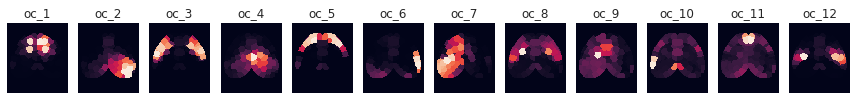

In [8]:
x = sv.gam_all.mean(0)
x /= x.sum(0, keepdims=True)
x_arr = sv.pi2arr(x, cortex_only=True)

fig, axes = create_figure(1, k, (13.5, 4) if k == 7 else (12, 6))

for ax, idx in zip(axes.ravel(), range(1, k + 1)):
    im = ax.imshow(x_arr[idx], cmap='rocket', vmin=0)
    ax.set_title(f"oc_{idx}")
remove_ticks(axes)
plt.show()

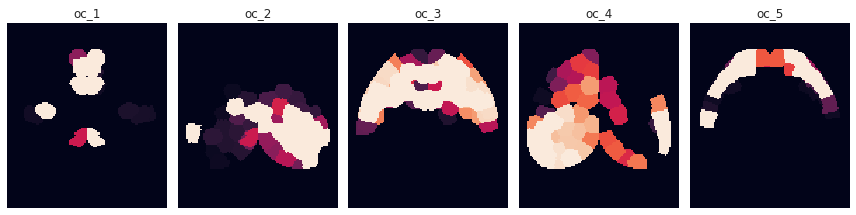

In [12]:
x = sv.gam_all[np.argmin(var_mean)].copy()
x /= x.sum(0, keepdims=True)
x_arr = svinet.pi2arr(x, cortex_only=True)

fig, axes = create_figure(1, k, (13.5, 4) if k == 7 else (12, 6))

for ax, idx in zip(axes.ravel(), range(1, k + 1)):
    im = ax.imshow(x_arr[idx], cmap='rocket', vmin=0)
    ax.set_title(f"oc_{idx}")
remove_ticks(axes)
plt.show()

(0.0, 1.0)

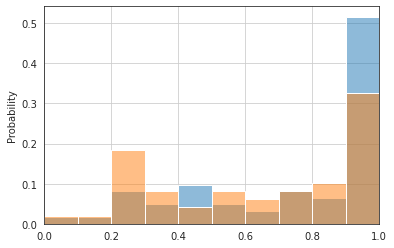

In [13]:
i = 2

x = sv.gam_all[np.argmin(var_mean)].copy()
x /= x.sum(0, keepdims=True)
y = np.round(x[i], 2).copy()
y[np.isnan(y)] = 0.
sns.histplot(y[y > 0], bins=np.linspace(0, 1, 11), stat='probability', alpha=0.5, color='C0')

x = sv.gam_all[np.argmax(var_mean)].copy()
x /= x.sum(0, keepdims=True)
y = np.round(x[i], 2).copy()
y[np.isnan(y)] = 0.
sns.histplot(y[y > 0], bins=np.linspace(0, 1, 11), stat='probability', alpha=0.5, color='C1')

plt.grid()
plt.xlim(0, 1)

In [14]:
g = sv.gam_all[np.argmin(var_mean)].copy()
x = g.copy()
x /= x.sum(0, keepdims=True)
y = np.round(x, 2).copy()
bad_nodes = np.where(np.isnan(y).sum(0))[0]

In [15]:
node = 9
y[:, node], g[:, node]

(
    array([0.  , 0.  , 0.57, 0.42, 0.  ]),
    array([ 0.18721665,  0.18740383, 36.99971095, 27.01834856,  0.18737576])
)

In [16]:
rng = get_rng()
num_expts = 1
starting_seed = rng.choice(len(sv.gam_all))
g = sv.gam_all[starting_seed].copy()

bad_all = []
for i in tqdm(range(0, len(sv.gam_all))):
    if i == starting_seed:
        continue
    
    _g = sv.gam_all[i]
    pi = _g / _g.sum(0, keepdims=True)
    bad_nodes = np.where(np.isnan(pi).sum(0))[0]
    bad_all.extend(list(bad_nodes))
    good_nodes = np.delete(range(sv.gam_all.shape[-1]), bad_nodes)
    ct_d = {}
    for node in good_nodes:
        ct_d[node] = rng.multinomial(num_expts, pi[:, node])
    for node, ct in ct_d.items():
        g[:, node] += ct

  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
pi = g / g.sum(0, keepdims=True)
nans = np.isnan(pi).sum(0).astype(bool)

In [18]:
collections.Counter(bad_all).most_common()

[(129, 999)]

In [19]:
xxx = sv.gam_all.mean(0)
xxx[:, nans] = 0
pi[:, nans] = 0

In [20]:
d = sp_dist.cdist(sv.gam_all.mean(0), pi, metric='cosine')
s = dist2sim(d)
s

array([[0.99834723, 0.28506459, 0.33505556, 0.46321933, 0.2143671 ],
       [0.26267878, 0.99844466, 0.08304562, 0.3983465 , 0.11012701],
       [0.33987397, 0.08528282, 0.99964399, 0.107075  , 0.17495189],
       [0.4588291 , 0.38826   , 0.10614854, 0.99858001, 0.10484066],
       [0.20875347, 0.11015939, 0.17916617, 0.10009517, 0.99947285]])

<matplotlib.image.AxesImage object at 0x7f9c8879c040>

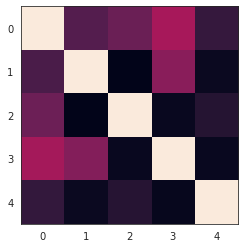

In [21]:
plt.imshow(s)

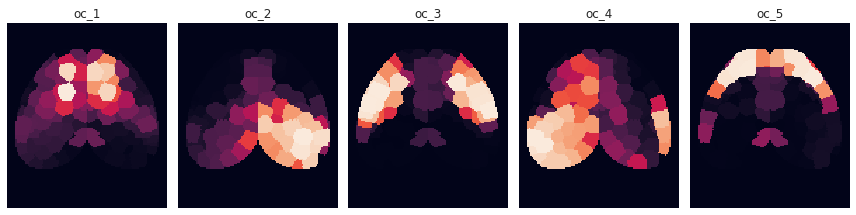

In [22]:
x_arr = svinet.pi2arr(pi, cortex_only=True)

fig, axes = create_figure(1, k, (13.5, 4) if k == 7 else (12, 6))

for ax, idx in zip(axes.ravel(), range(1, k + 1)):
    im = ax.imshow(x_arr[idx], cmap='rocket', vmin=0)
    ax.set_title(f"oc_{idx}")
remove_ticks(axes)
plt.show()

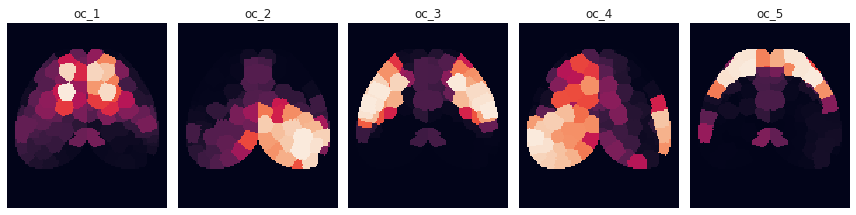

In [23]:
_g = sv.gam_all.mean(0)
_pi = _g / _g.sum(0, keepdims=True)
x_arr = svinet.pi2arr(_pi, cortex_only=True)

fig, axes = create_figure(1, k, (13.5, 4) if k == 7 else (12, 6))

for ax, idx in zip(axes.ravel(), range(1, k + 1)):
    im = ax.imshow(x_arr[idx], cmap='rocket', vmin=0)
    ax.set_title(f"oc_{idx}")
remove_ticks(axes)
plt.show()

In [6]:
sv.gam_all.shape

(1000, 4, 138)

In [7]:
dists = []
for i in range(len(sv.gam_all)):
    d = sp_dist.cdist(sv.gam_all[i], sv.gam_all.mean(0), metric='cosine')
    dists.append(np.diag(d).mean())

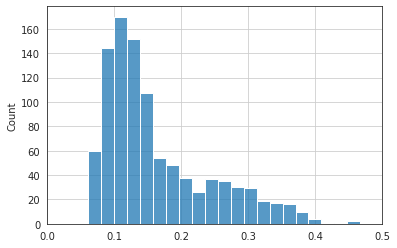

In [8]:
sns.histplot(dists)
plt.xlim(0, 0.5)
plt.grid()

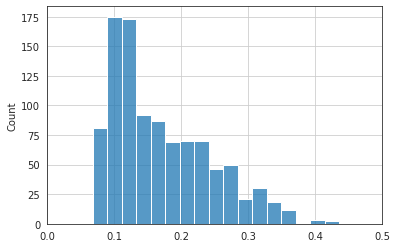

In [29]:
sort_ids = np.argsort(dists)

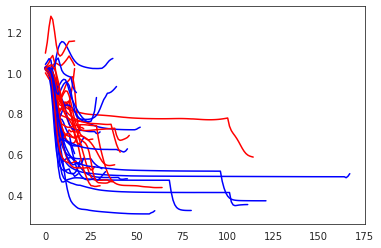

In [30]:
for i in range(20):
    vld_min = list(sv.get_result_dict().values())[sort_ids[i]]['valid']
    vld_max = list(sv.get_result_dict().values())[sort_ids[::-1][i]]['valid']

    plt.plot(vld_min['nll'], 'b')
    plt.plot(vld_max['nll'], 'r')

In [31]:
xx = sv.pi_all.mean(0)
np.isnan(xx).sum(0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0,
       0, 0, 0, 0, 0, 0])

## BOOTSTRAP (light)

In [7]:
import re

def _extract_seed(x):
    x = next(e for e in str(x).split('-') if 'seed' in e)
    x = re.sub(r"\D", "", x)
    return int(x)

In [8]:
# find shared seeds

seeds_shared = set(range(1, 1000 + 1))
for sub in mice.cfg.sub_ids:
    data_ses = []
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        df = result['svinet_all'][key].pi_cut_df
        s = list(map(_extract_seed, df['run']))
        seeds_shared.intersection_update(set(s))
len(seeds_shared)

835

In [10]:
intervals = None

data_all = []
for sub in tqdm(mice.cfg.sub_ids):
    data_ses = []
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        df = result['svinet_all'][key].pi_cut_df.copy()
        if intervals is None:
            intervals = df.interval.unique()
        df = pd.concat([pd.DataFrame(columns=['seed']), df], axis=1)
        df['seed'] = list(map(_extract_seed, df['run']))
        df = df.loc[df['seed'].isin(seeds_shared)]
        df = df.set_index([df['seed'], df['oc_idx'], df['interval']])
        df = df.drop(columns=['run', 'seed', 'oc_idx', 'interval', 'count'])
        data = df.unstack().values
        data = data.reshape((len(seeds_shared), k, len(intervals)))
        data = data[:, list(result['perms'][key].values()), :]
        data_ses.append(np.expand_dims(data, axis=0))
    data_ses = np.concatenate(data_ses)
    data_all.append(np.expand_dims(data_ses, axis=0))
data_all = np.concatenate(data_all)
data_all.shape

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 3, 835, 6, 10)

In [11]:
n_boot = int(1e5)

booted = bootstrap(
    data=data_all,
    n_boot=n_boot,
)
booted.shape

  0%|          | 0/100000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(100000, 6, 10)

<AxesSubplot:xlabel='mean', ylabel='Density'>

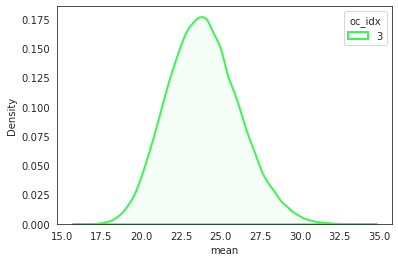

In [12]:
i = 2
j = 9

_df = pd.DataFrame({
    'interval': [intervals[j]] * len(booted),
    'oc_idx': [i + 1] * len(booted),
    'mean': booted[:, i, j],
})
sns.kdeplot(
    data=_df,
    x='mean',
    hue='oc_idx',
    fill=True,
    alpha=0.05,
    lw=2,
    palette=svinet.colors,
)

<AxesSubplot:xlabel='mean', ylabel='Density'>

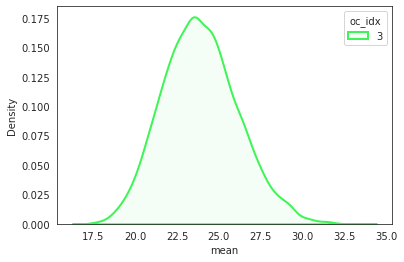

In [13]:
props = {
    'boxprops': {'alpha': 0.5, 'edgecolor': 'k'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
meanprops = {
    "marker": "o",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": "6",
}

whisk = {
    5.0: [2.5, 97.5],
    1.0: [0.5, 99.5],
    0.1: [0.05, 99.95],
    0.0: [0.0, 100.0],
}
figs = []
sups = []
for ci, whisk_val in tqdm(whisk.items()):
    nrows = 2
    ncols = len(intervals)
    fig, axes = create_figure(nrows, ncols, (4 * ncols, 3.8 * nrows), 'ticks', 'col', False)

    for j, intvl in enumerate(intervals):
        dlist = []
        for i in range(k):
            dlist.append({
                'interval': [intervals[j]] * len(booted),
                'oc_idx': [i + 1] * len(booted),
                'mean': booted[:, i, j].astype(float),
            })
        _df = pd.DataFrame(merge_dicts(dlist))
        sns.kdeplot(
            data=_df,
            x='mean',
            hue='oc_idx',
            cumulative=False,
            fill=True,
            alpha=0.05,
            lw=2,
            palette=svinet.colors,
            ax=axes[0, j],
        )
        axes[0, j].set_title(f"bin: {intvl}\n", fontsize=15)

        sns.boxplot(
            data=_df,
            x='mean',
            y='oc_idx',
            palette=svinet.colors,
            dodge=True,
            orient='h',
            width=0.6,
            whis=whisk_val,
            # fliersize=1,
            showfliers=False,
            showmeans=True,
            meanprops=meanprops,
            ax=axes[1, j],
            **props,
        )
        for i in range(2):
            axes[i, j].grid(axis='both', ls=':')
            axes[i, j].axvline(0, color='dimgrey', lw=0.8, ls='--')
        if j == 0:
            axes[0, j].set_ylabel('kde (mice)\n', fontsize=15)
            axes[1, j].set_ylabel('box (mice)\n', fontsize=15)
        else:
            for i in range(2):
                axes[i, j].set_ylabel('')

    msg = f"Whiskers at {ci} % confidence interval: {whisk_val}"
    sup = fig.suptitle(msg, fontsize=20, y=1.07)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = [
    'kde',
    f"bins-{len(intervals)}",
    f"boot-{n_boot:1.0e}",
]
save_file = f"{'_'.join(save_file)}.pdf"
save_file = pjoin(figs_dir, save_file)
print(save_file)
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')

  0%|          | 0/4 [00:00<?, ?it/s]

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6/kde_bins-10_boot-1e+05.pdf

done.

In [14]:
props = {
    'boxprops': {'alpha': 0.5, 'edgecolor': 'k'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
meanprops = {
    "marker": "o",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": "6",
}

whisk = {
    5.0: [2.5, 97.5],
    1.0: [0.5, 99.5],
    0.1: [0.05, 99.95],
    0.0: [0.0, 100.0],
}
figs = []
sups = []
for ci, whisk_val in tqdm(whisk.items()):
    nrows = 2
    ncols = len(intervals)
    fig, axes = create_figure(nrows, ncols, (4 * ncols, 3.8 * nrows), 'ticks', 'col', False)

    for j, intvl in enumerate(intervals):
        dlist = []
        for i in range(k):
            dlist.append({
                'interval': [intervals[j]] * len(booted),
                'oc_idx': [i + 1] * len(booted),
                'mean': booted[:, i, j],
            })
        _df = pd.DataFrame(merge_dicts(dlist))
        sns.histplot(
            data=_df,
            x='mean',
            hue='oc_idx',
            alpha=0.5,
            bins=100,
            palette=svinet.colors,
            ax=axes[0, j],
        )
        axes[0, j].set_title(f"bin: {intvl}\n", fontsize=15)

        sns.boxplot(
            data=_df,
            x='mean',
            y='oc_idx',
            palette=svinet.colors,
            dodge=True,
            orient='h',
            width=0.6,
            whis=whisk_val,
            # fliersize=1,
            showfliers=False,
            showmeans=True,
            meanprops=meanprops,
            ax=axes[1, j],
            **props,
        )
        for i in range(2):
            axes[i, j].grid(axis='both', ls=':')
            axes[i, j].axvline(0, color='dimgrey', lw=0.8, ls='--')
        if j == 0:
            axes[0, j].set_ylabel('kde (mice)\n', fontsize=15)
            axes[1, j].set_ylabel('box (mice)\n', fontsize=15)
        else:
            for i in range(2):
                axes[i, j].set_ylabel('')

    msg = f"Whiskers at {ci} % confidence interval: {whisk_val}"
    sup = fig.suptitle(msg, fontsize=20, y=1.07)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = [
    'hist',
    # f"seeds-{'avg' if avg_seeds else 'single'}",
    f"bins-{len(intervals)}",
    f"boot-{n_boot:1.0e}",
]
save_file = f"{'_'.join(save_file)}.pdf"
save_file = pjoin(figs_dir, save_file)
print(save_file)
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')

  0%|          | 0/4 [00:00<?, ?it/s]

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6/hist_bins-10_boot-1e+05.pdf

done.

## Scipy bootstrap

In [15]:
my_statistic = get_statistic_fn(
    axis_sub=-1,
    axis_ses=0,
    axis_seed=1,
    keepdims=False,
)
n_resamples = 10000
batch = 2000
dlist = []
for method in tqdm(['percentile', 'basic', 'bca']):
    for ci in tqdm([95, 99, 99.9, 99.999, 99.99999], leave=False):
        boot = sp_stats.bootstrap(
            data=(data_all,),
            statistic=my_statistic,
            confidence_level=ci/100,
            n_resamples=n_resamples,
            batch=batch,
            method=method,
            random_state=mice.cfg.random_state,
        )
        for i in range(k):
            for j, intvl in enumerate(intervals):
                _res = {
                    'se': boot.standard_error[i, j],
                    'low': boot.confidence_interval.low[i, j],
                    'high': boot.confidence_interval.high[i, j],
                }
                dlist.append({
                    'ci': [ci] * len(_res),
                    'method': [method] * len(_res),
                    'oc_idx': [i + 1] * len(_res),
                    'interval': [intvl] * len(_res),
                    'label': _res.keys(),
                    'value': _res.values(),
                })
df_boot = pd.DataFrame(merge_dicts(dlist))
_ = save_obj(
    obj=df_boot,
    file_name=f"boot_{now()}",
    save_dir=tmp_dir,
    mode='df',
)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[PROGRESS] 'boot_(2021_08_19).df' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

In [16]:
dlist = []
for ci in df_boot.ci.unique():
    q = np.round((100 - ci) / 2, 3)
    vals = np.percentile(
        a=booted,
        q=[q, 100 - q],
        axis=0,
    )
    for i in range(k):
        for j, intvl in enumerate(intervals):
            _res = {
                'low': vals[0, i, j],
                'high': vals[1, i, j],
            }
            dlist.append({
                'ci': [ci] * len(_res),
                'method': ['me'] * len(_res),
                'oc_idx': [i + 1] * len(_res),
                'interval': [intvl] * len(_res),
                'label': _res.keys(),
                'value': _res.values(),
            })
df_boot2 = pd.DataFrame(merge_dicts(dlist))

In [17]:
df = pd.concat([df_boot, df_boot2], axis=0)

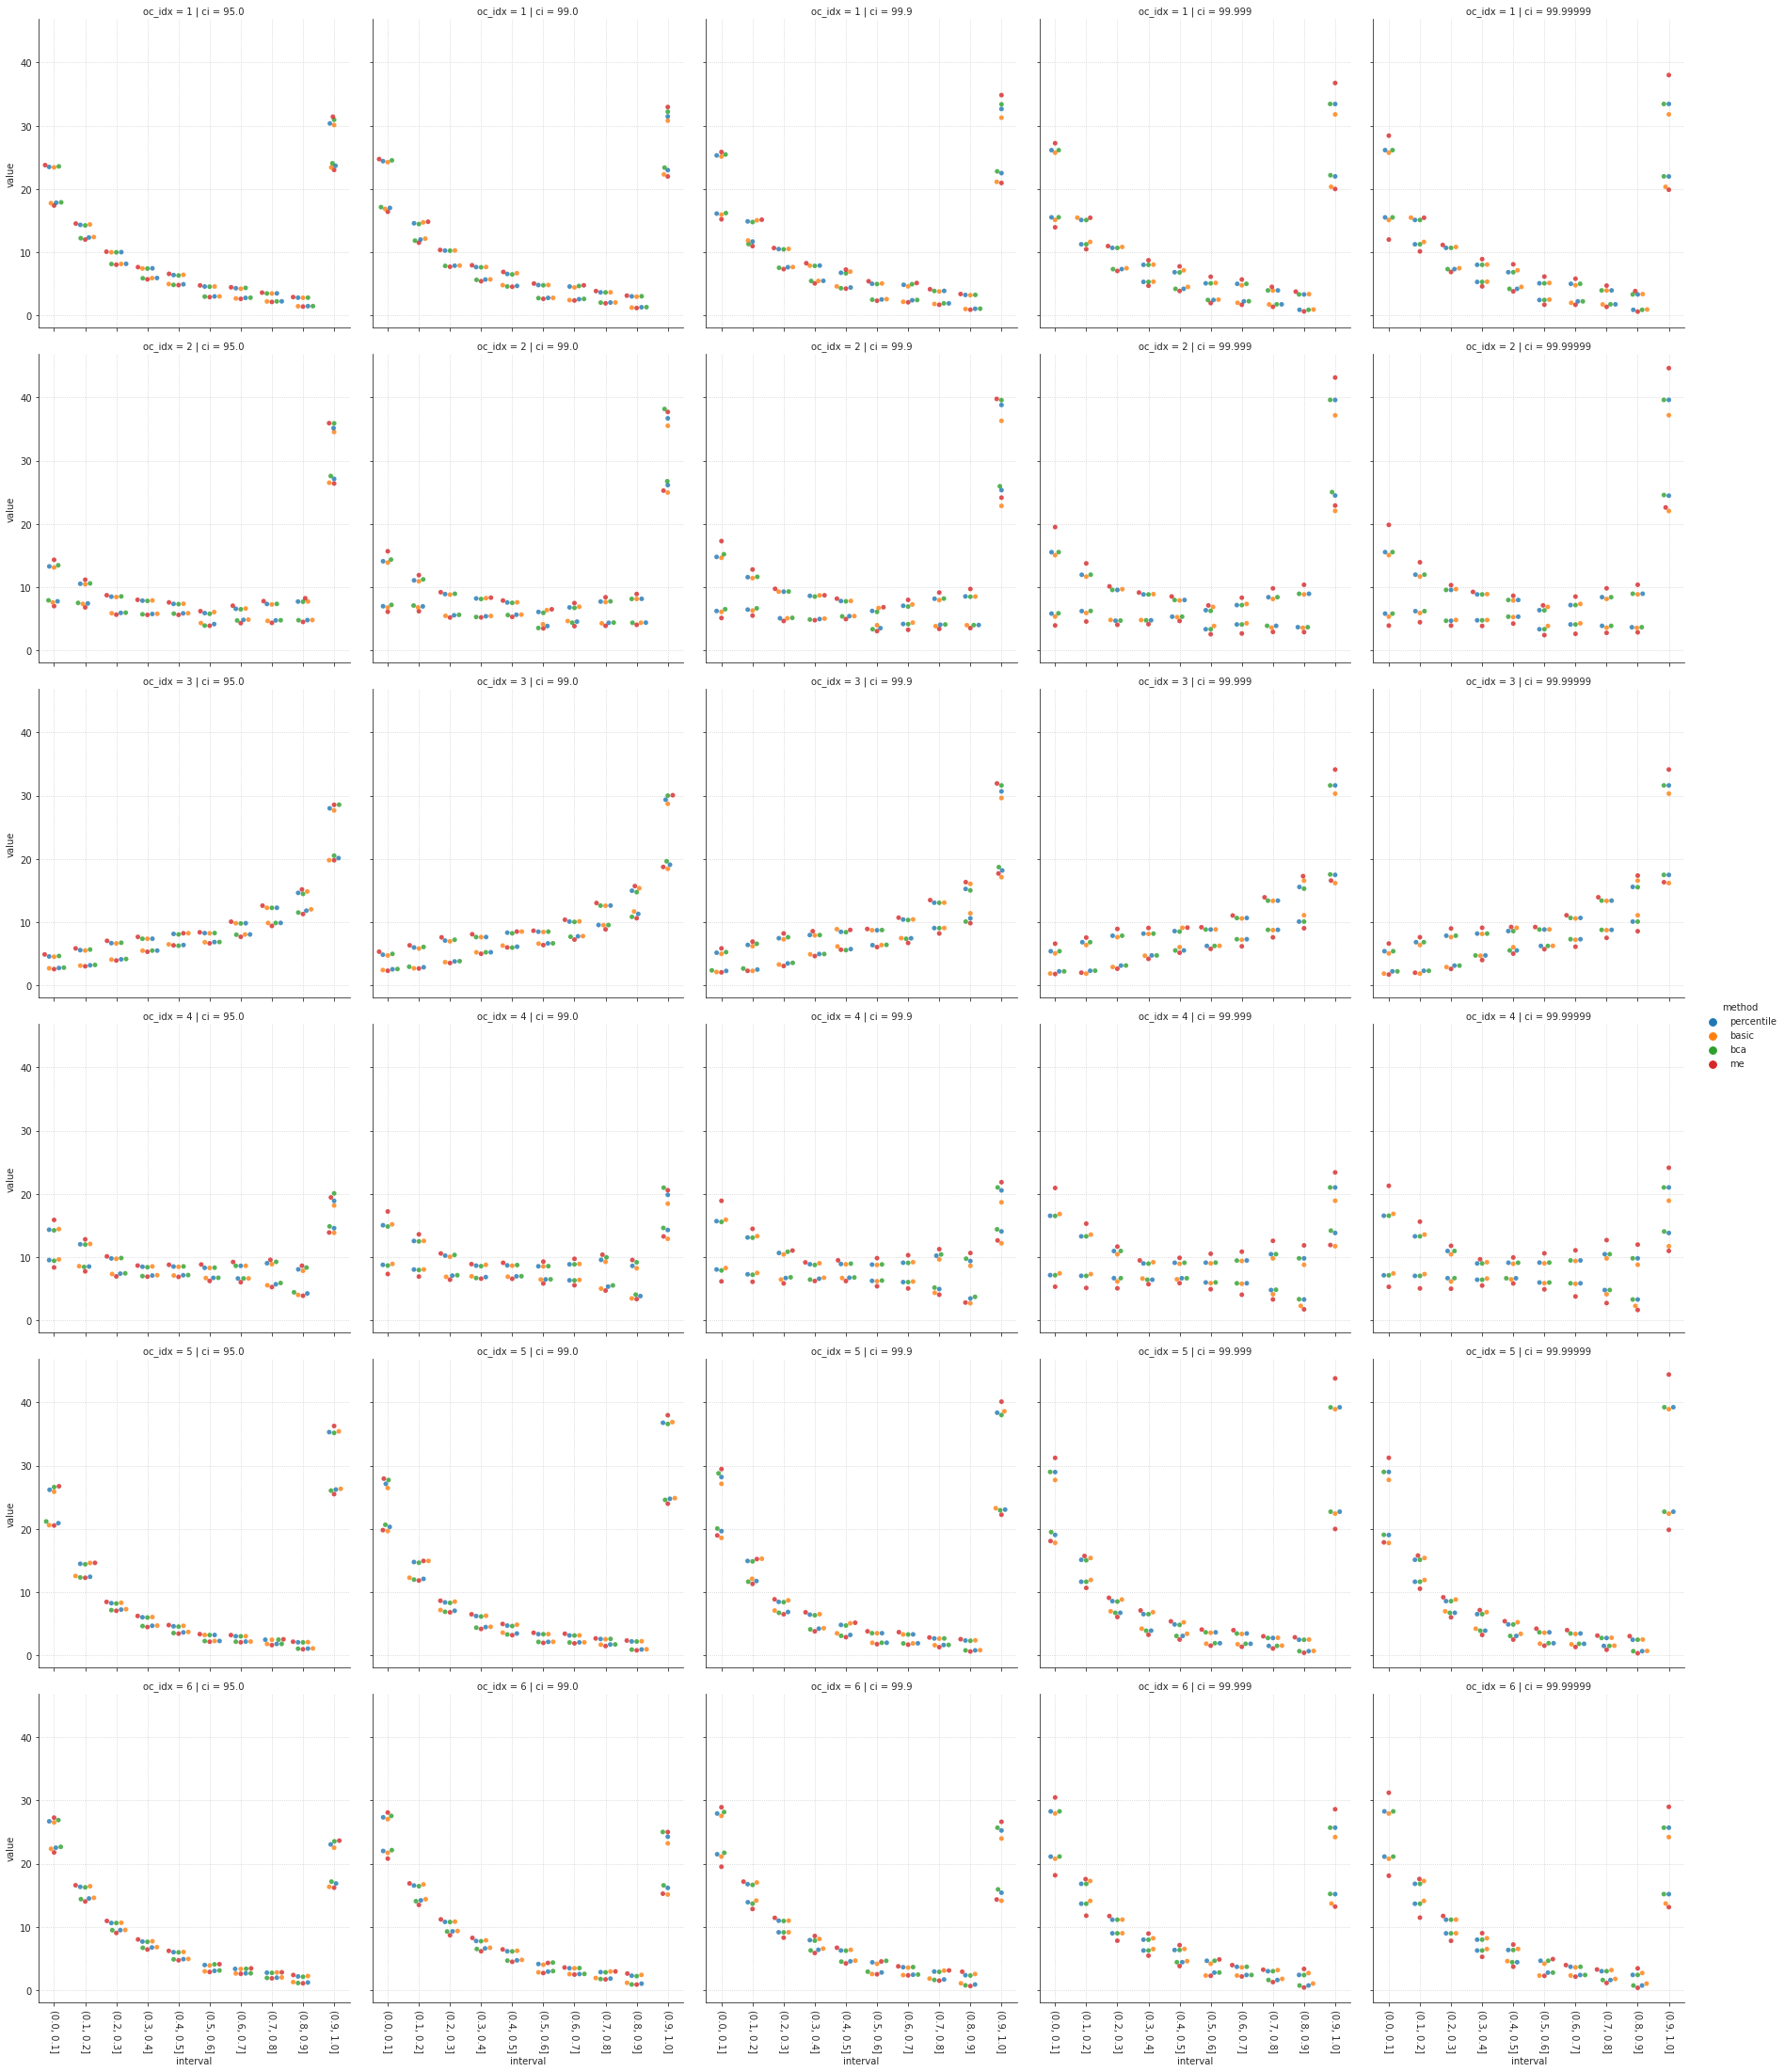

In [18]:
fg = sns.catplot(
    data=df.loc[df.label != 'se'],
    x='interval',
    y='value',
    hue='method',
    col='ci',
    row='oc_idx',
    alpha=0.8,
    kind='swarm',
)
for ax in fg.axes.ravel():
    ax.tick_params(axis='x', rotation=-90)
    ax.grid(ls=':')
fg.fig.savefig(pjoin('/home/hadi/Dropbox/Proj-Overlap-Figs', 'bootstrap_methods.pdf'), bbox_inches='tight')

In [19]:
_df = df.loc[(df.label == 'se') & (df.method == 'bca')]
_df = _df.groupby(['oc_idx', 'interval']).mean().unstack()['value']
se = _df.values

In [22]:
se

array([[1.44000014, 0.50645283, 0.47366711, 0.39139587, 0.3757412 ,
        0.4008134 , 0.3941098 , 0.31676282, 0.34258135, 1.70554934],
       [1.42247348, 0.794226  , 0.64971593, 0.5458566 , 0.38422278,
        0.44638919, 0.45336411, 0.66401799, 0.74546284, 2.05819825],
       [0.46864999, 0.6176819 , 0.65504137, 0.47874197, 0.44765885,
        0.35927641, 0.4536974 , 0.60681251, 0.72524958, 2.02893449],
       [1.24348158, 0.90269448, 0.61514333, 0.35500225, 0.34709207,
        0.4064193 , 0.51046265, 0.84999755, 0.97955941, 1.12265918],
       [1.34786999, 0.52582919, 0.26172173, 0.3410441 , 0.25020869,
        0.24122139, 0.21711939, 0.17094741, 0.25317038, 2.34372141],
       [1.06740997, 0.46834244, 0.29147453, 0.23875345, 0.28527382,
        0.23719917, 0.18041175, 0.20242827, 0.24453277, 1.58111318]])

In [23]:
real_data = get_statistic_fn(keepdims=False)(data_all)
real_data

array([[20.63813493, 13.38183128,  9.09936356,  6.69686612,  5.69966165,
         3.81784734,  3.52523162,  2.87745916,  2.15805504, 26.90429701],
       [10.45831068,  8.96066124,  7.20773492,  6.84934245,  6.63925177,
         5.13108655,  5.74562793,  6.02690976,  6.28586143, 30.83937079],
       [ 3.65320108,  4.36218355,  5.3944731 ,  6.45097062,  7.32716572,
         7.55767205,  8.95279274, 11.08288271, 13.33864867, 23.90433695],
       [11.98736993, 10.30613427,  8.56631683,  7.81519496,  7.80895961,
         7.51118142,  7.63436376,  7.30106418,  6.05138399, 16.37189279],
       [23.37762927, 13.51170043,  7.77203618,  5.3638117 ,  4.14905854,
         2.7466499 ,  2.60623348,  2.13761085,  1.58374877, 30.80730301],
       [24.53618962, 15.47960419, 10.08832066,  7.2592225 ,  5.49006501,
         3.49831128,  3.02389404,  2.41007333,  1.74423348, 19.70700139]])

In [24]:
dlist = []
ci_all = [95, 99.99, 99.9999, 99.999999, 99.99999999, 100 * (1 - 0.05 / (6 * 10))]
for ci in sorted(ci_all):
    p = np.round(1 - ci / 100, 13)
    t = abs(sp_stats.t.ppf(1 - p, 9))
    low = real_data - se * t
    high = real_data + se * t
    for i in range(k):
        for j, intvl in enumerate(intervals):
            _res = {
                'low': low[i, j],
                'real': real_data[i, j],
                'high': high[i, j],
            }
            dlist.append({
                'p': [p] * len(_res),
                't': [t] * len(_res),
                'ci': [ci] * len(_res),
                'oc_idx': [i + 1] * len(_res),
                'interval': [intvl] * len(_res),
                'label': _res.keys(),
                'value': _res.values(),
            })
df_t = pd.DataFrame(merge_dicts(dlist))

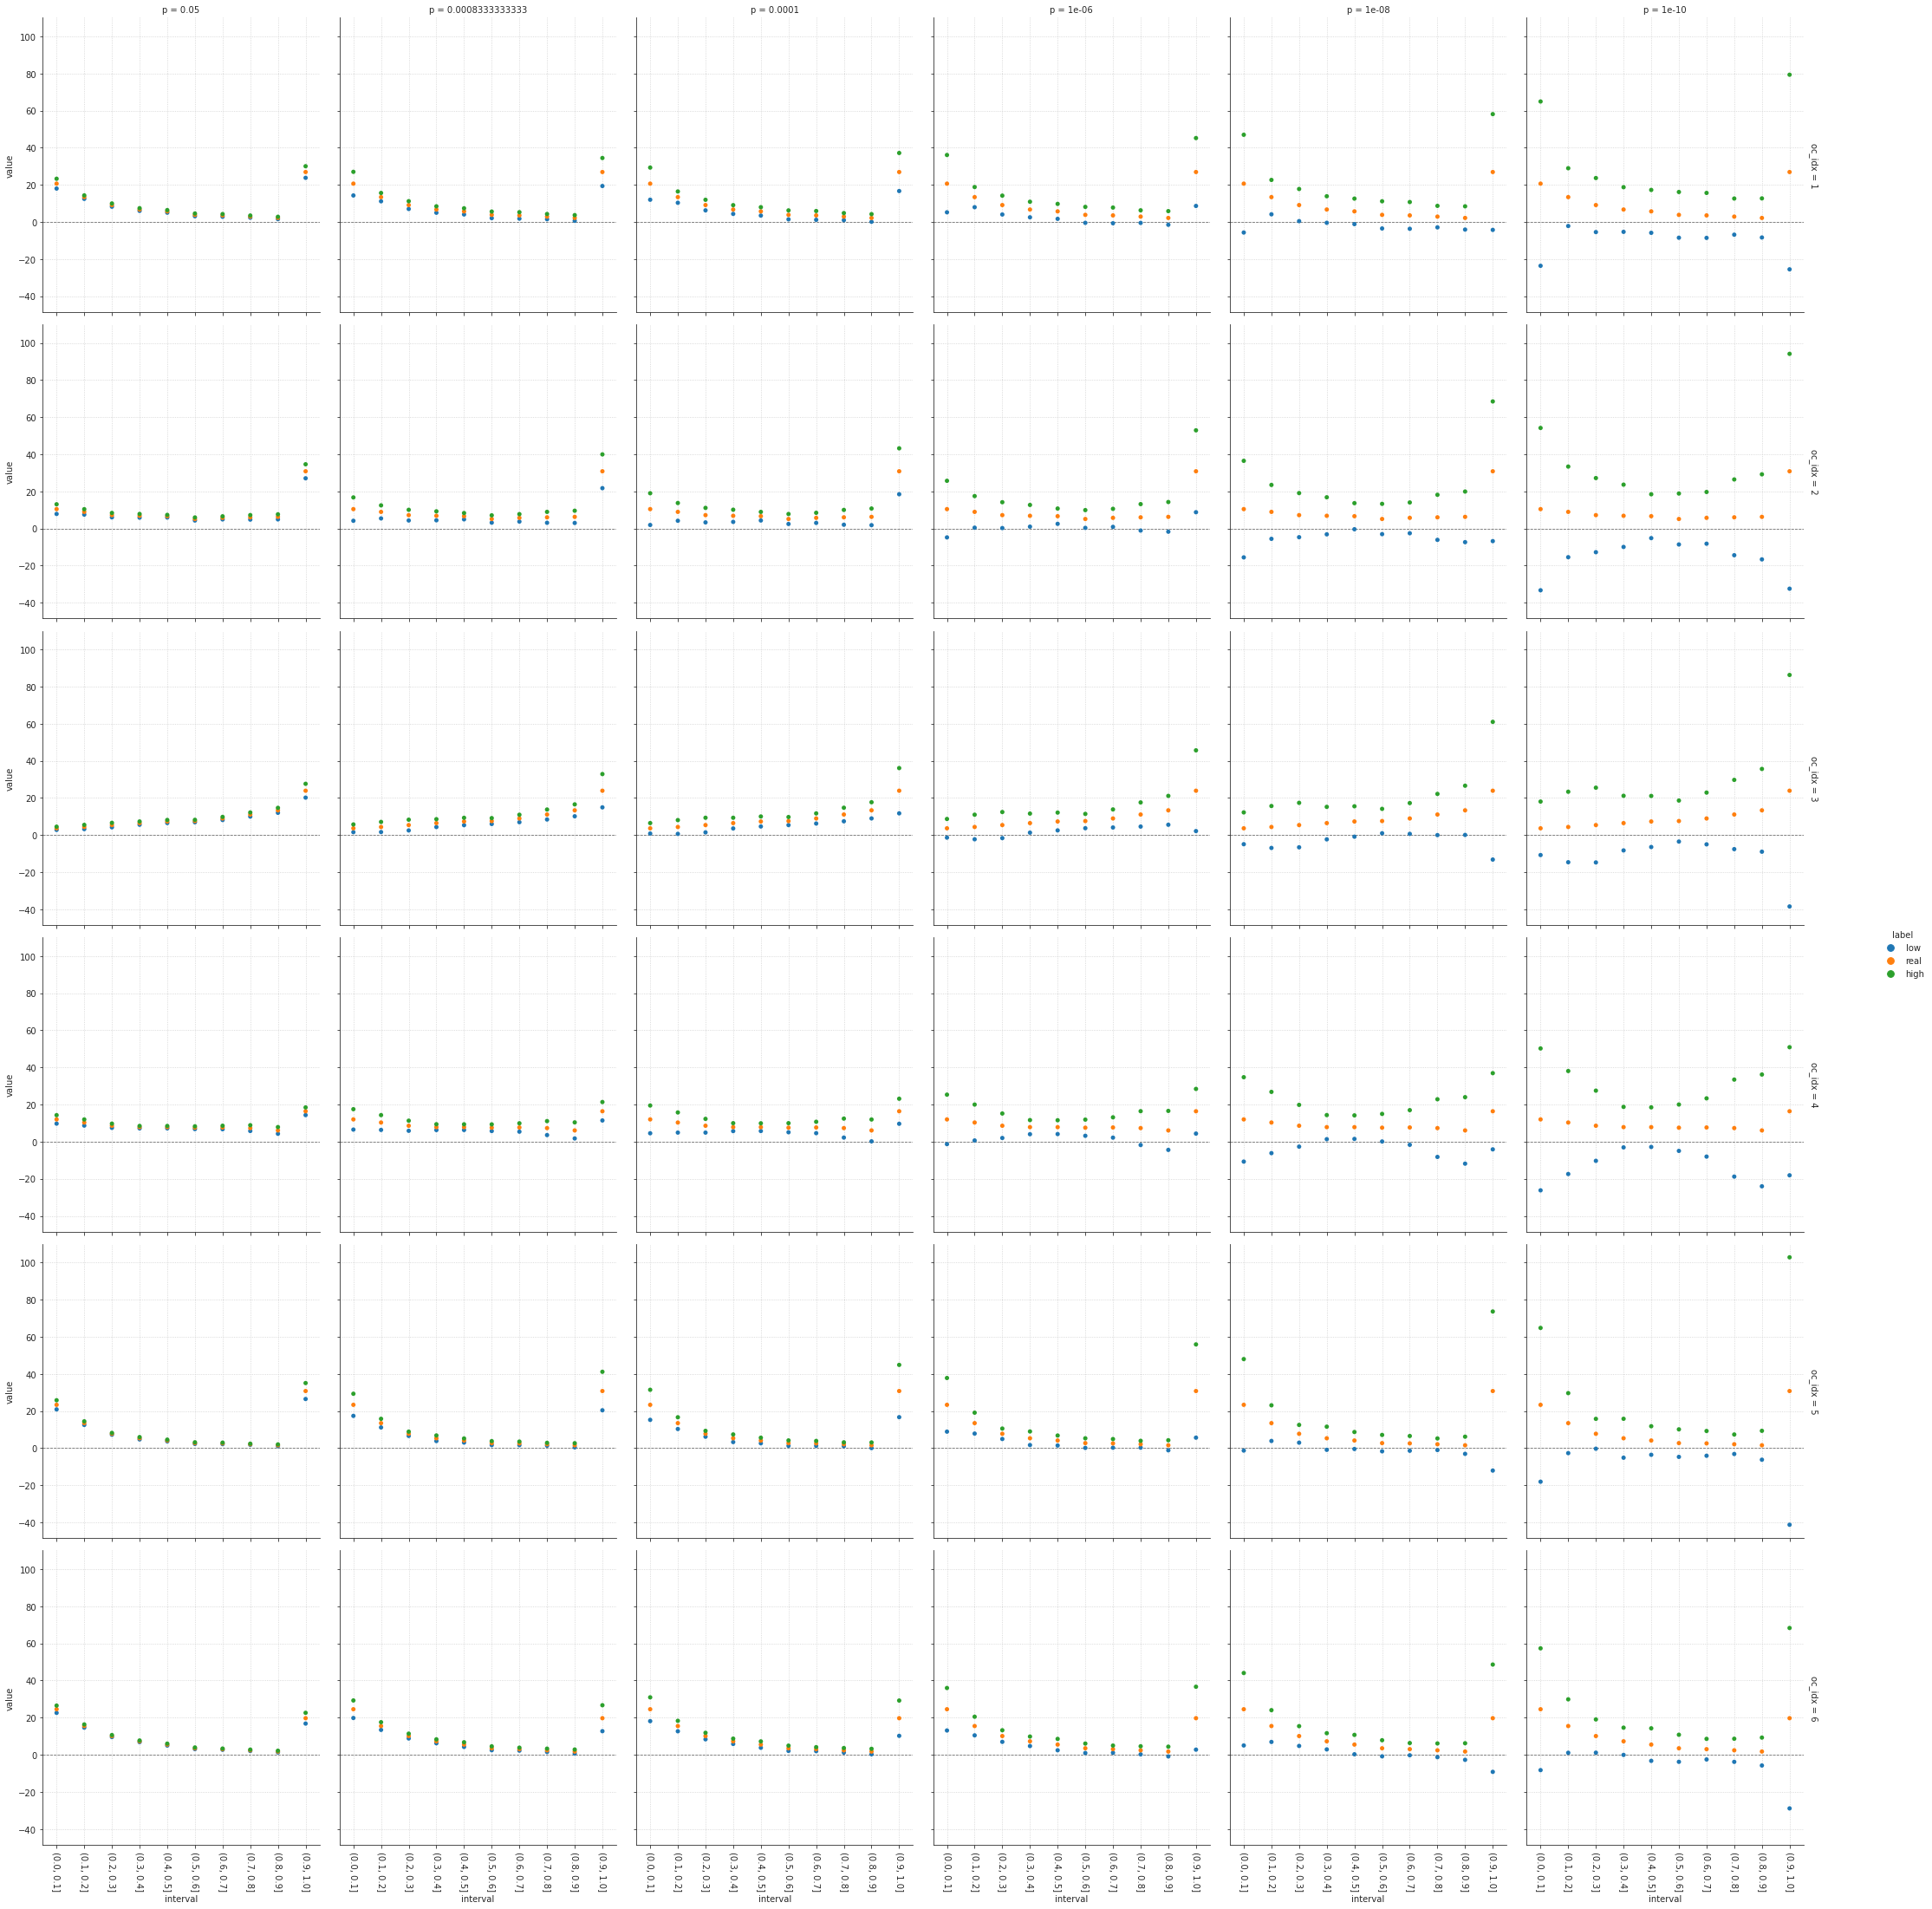

In [25]:
fg = sns.catplot(
    data=df_t,
    x='interval',
    y='value',
    hue='label',
    row='oc_idx',
    col='p',
    col_order=sorted(df_t.p.unique(), reverse=True),
    jitter=False,
    margin_titles=True,
)
for ax in fg.axes.ravel():
    ax.axhline(0, color='dimgrey', lw=0.8, ls='--')
    ax.tick_params(axis='x', rotation=-90)
    ax.grid(ls=':')
fg.fig.savefig(pjoin('/home/hadi/Dropbox/Proj-Overlap-Figs', 'se-bca_with-t.pdf'), bbox_inches='tight')

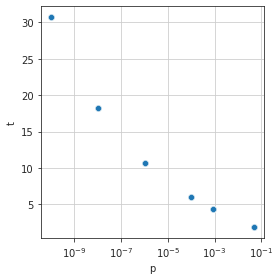

In [26]:
fig, ax = create_figure(1, 1, (4, 4), 'ticks')
sns.scatterplot(data=df_t, x='p', y='t', ax=ax)
ax.set_xscale('log')
ax.grid()

In [27]:
booted.shape

(100000, 6, 10)

<AxesSubplot:ylabel='Count'>

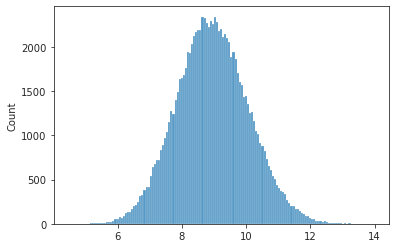

In [28]:
sns.histplot(booted[:, 1, 1])

In [29]:
booted.dtype

dtype('float128')

In [30]:
skew, pval = sp_stats.skewtest(booted.astype(float), axis=0, alternative='two-sided')

In [31]:
skew

array([[-3.55255543e+00, -4.15424426e+01, -7.96456704e+00,
        -1.91605420e+00,  1.30924403e+01,  1.16534229e+01,
         2.03057242e+01,  1.10316313e+01, -3.80672282e-02,
         3.60276459e+01],
       [ 3.13012422e+01,  1.44520545e+01,  1.95045352e+00,
        -1.46516474e+01, -1.03091271e+01, -2.52047527e+01,
        -1.54731040e+01,  2.44077499e+01,  3.04432010e+01,
         3.56397150e+01],
       [ 3.98501011e+01,  2.69935774e+01,  2.63345239e+01,
         2.17026784e+01, -1.93170165e+01, -5.83685824e+00,
        -2.68362354e+01, -1.92562974e+01, -2.18342894e+01,
         3.16962371e+01],
       [ 2.16773448e+01, -9.18517519e-01, -9.03833188e+00,
        -2.10432121e+01,  7.86312912e+00,  1.36500080e+01,
         4.77254429e+00,  3.17693203e+01,  3.99147613e+01,
         4.58529698e+01],
       [ 4.21542672e+01, -3.28549705e+01, -2.07361110e+01,
        -1.47413389e+01, -2.97614126e+01,  1.09093877e+01,
         2.31352961e+01, -1.20126281e+01,  7.16841278e-01,
         1.03100855e+01],
       [-1.23080824e+01, -5.66385085e+01, -3.51266742e+01,
        -6.64322385e+00, -3.62682056e+00,  1.05828019e+01,
         1.46400173e+01, -2.01324094e+01,  8.34365340e+00,
         3.20783118e+01]])

In [32]:
max_ids = np.unravel_index(np.argmax(np.abs(skew)), skew.shape)
min_ids = np.unravel_index(np.argmin(np.abs(skew)), skew.shape)

Text(0.5, 1.0, 'skewedness: -56.64')

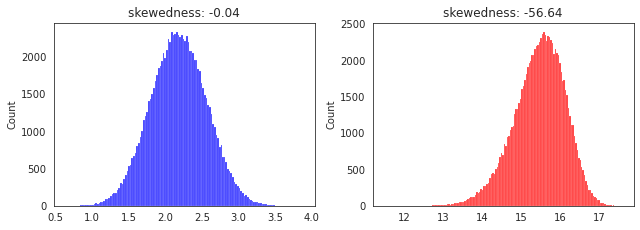

In [33]:
fig, axes = create_figure(1, 2, (9, 3.3))

sns.histplot(booted[:, min_ids[0], min_ids[1]], color='b', ax=axes[0])
sns.histplot(booted[:, max_ids[0], max_ids[1]], color='r', ax=axes[1])

axes[0].set_title(f"skewedness: {skew[min_ids[0], min_ids[1]]:0.2f}")
axes[1].set_title(f"skewedness: {skew[max_ids[0], max_ids[1]]:0.2f}")

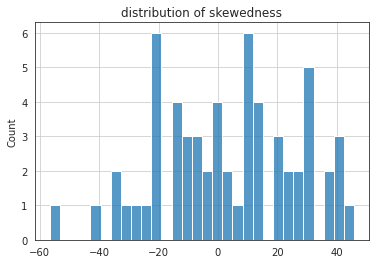

In [34]:
sns.histplot(skew.ravel(), bins=30)
plt.title('distribution of skewedness')
plt.grid()

In [35]:
i, j = max_ids
booted_boxcox, maxlog = sp_stats.boxcox(booted[:, i, j].astype(float))

In [36]:
maxlog

4.561229152754668

<AxesSubplot:ylabel='Count'>

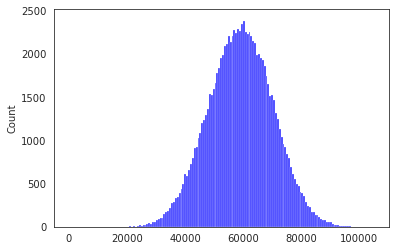

In [37]:
sns.histplot(booted_boxcox, color='b')
sns.histplot(booted[:, i, j].astype(float), color='r')

Text(0.5, 1.0, 'skewedness: -56.64')

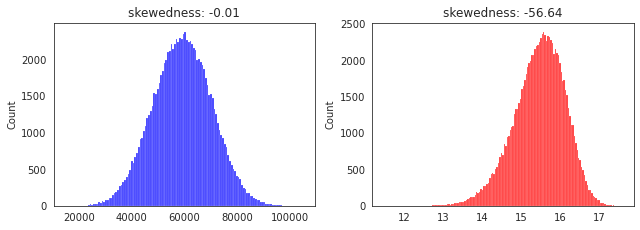

In [38]:
fig, axes = create_figure(1, 2, (9, 3.3))

sns.histplot(booted_boxcox, color='b', ax=axes[0])
sns.histplot(booted[:, max_ids[0], max_ids[1]], color='r', ax=axes[1])

axes[0].set_title(f"skewedness: {sp_stats.skew(booted_boxcox):0.2f}")
axes[1].set_title(f"skewedness: {skew[max_ids[0], max_ids[1]]:0.2f}")

In [39]:
np.std(booted_boxcox)

11047.2791031827

In [40]:
booted_tr = np.zeros(booted.shape)
lmbda = np.zeros(booted.shape[1:])
for i in range(booted.shape[1]):
    for j in range(booted.shape[2]):
        x, lam = sp_stats.boxcox(booted[:, i, j].astype(float))
        booted_tr[:, i, j] = x
        lmbda[i, j] = lam

In [41]:
skew_tr, _ = sp_stats.skewtest(booted_tr.astype(float), axis=0, alternative='two-sided')

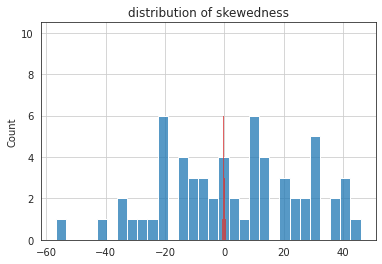

In [42]:
sns.histplot(skew.ravel(), bins=30)
sns.histplot(skew_tr.ravel(), bins=30, color='C3')
plt.title('distribution of skewedness')
plt.grid()

In [43]:
real_data

array([[20.63813493, 13.38183128,  9.09936356,  6.69686612,  5.69966165,
         3.81784734,  3.52523162,  2.87745916,  2.15805504, 26.90429701],
       [10.45831068,  8.96066124,  7.20773492,  6.84934245,  6.63925177,
         5.13108655,  5.74562793,  6.02690976,  6.28586143, 30.83937079],
       [ 3.65320108,  4.36218355,  5.3944731 ,  6.45097062,  7.32716572,
         7.55767205,  8.95279274, 11.08288271, 13.33864867, 23.90433695],
       [11.98736993, 10.30613427,  8.56631683,  7.81519496,  7.80895961,
         7.51118142,  7.63436376,  7.30106418,  6.05138399, 16.37189279],
       [23.37762927, 13.51170043,  7.77203618,  5.3638117 ,  4.14905854,
         2.7466499 ,  2.60623348,  2.13761085,  1.58374877, 30.80730301],
       [24.53618962, 15.47960419, 10.08832066,  7.2592225 ,  5.49006501,
         3.49831128,  3.02389404,  2.41007333,  1.74423348, 19.70700139]])

In [44]:
real_data_tr = (np.power(real_data, lmbda) - 1) / lmbda
real_data_tr

array([[2.50454293e+01, 1.59193069e+03, 1.39614681e+01, 6.14635961e+00,
        3.01350359e+00, 2.32329989e+00, 1.88412938e+00, 1.64348383e+00,
        1.15449440e+00, 2.24770269e+00],
       [4.66827914e+00, 5.16735003e+00, 5.77288382e+00, 1.01566014e+01,
        8.78109337e+00, 7.56372103e+00, 6.82902048e+00, 3.10680270e+00,
        2.88923802e+00, 2.29976317e+00],
       [1.59210077e+00, 2.27982916e+00, 2.68724773e+00, 2.70892298e+00,
        1.81295531e+01, 9.26652350e+00, 4.09578367e+01, 3.30144933e+01,
        5.31740244e+01, 3.49500266e+00],
       [6.25004052e+00, 9.50881057e+00, 1.08005278e+01, 2.75681319e+01,
        4.49704398e+00, 4.00936896e+00, 5.68082663e+00, 3.20074163e+00,
        2.76617460e+00, 1.55160059e+00],
       [1.30107310e+00, 7.26376743e+02, 3.83301122e+01, 7.17845363e+00,
        7.45114910e+00, 1.52463904e+00, 1.23109295e+00, 1.27909930e+00,
        5.80886861e-01, 1.41717378e+01],
       [9.06920490e+01, 5.85711571e+04, 2.90800332e+02, 9.42929047e+00,
        5.20197137e+00, 1.98667616e+00, 1.44068042e+00, 1.82700984e+00,
        7.23535123e-01, 3.42375103e+00]])

In [47]:
result['svinet_all'][key].pi_all.shape

(998, 6, 138)

In [53]:
pd.cut()

TypeError: cut() missing 2 required positional arguments: 'x' and 'bins'

In [ ]:
np.histogram()

In [6]:
result['pi'].shape

(4, 138)

<AxesSubplot:ylabel='Count'>

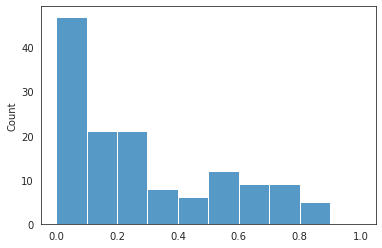

In [12]:
x = np.round(result['pi'][1], 2)
sns.histplot(x[x > 0], bins=np.linspace(0, 1, 11))

In [76]:
x[x > 0]

array([0.13, 0.13, 0.14, 0.15, 0.11, 0.06, 0.14, 0.17, 0.15, 0.06, 0.1 ,
       0.07, 0.09, 0.14, 0.06, 0.15, 0.09, 0.05, 0.05, 0.08, 0.07, 0.14,
       0.08, 0.07, 0.15, 0.11, 0.06, 0.11, 0.14, 0.11, 0.15, 0.1 , 0.09,
       0.16, 0.19, 0.13, 0.16, 0.21, 0.1 , 0.11, 0.18, 0.17, 0.2 , 0.09,
       0.13, 0.12, 0.3 , 0.06, 0.07, 0.08, 0.19, 0.05, 0.12, 0.08, 0.06,
       0.05, 0.21, 0.06, 0.05, 0.05, 0.06, 0.05, 0.05, 0.06, 0.19, 0.23,
       0.25, 0.21, 0.25, 0.14, 0.11, 0.15, 0.14, 0.11, 0.08, 0.14, 0.17,
       0.16, 0.06, 0.1 , 0.08, 0.15, 0.13, 0.06, 0.14, 0.11, 0.07, 0.06,
       0.11, 0.1 , 0.14, 0.12, 0.06, 0.15, 0.2 , 0.06, 0.12, 0.16, 0.21,
       0.14, 0.18, 0.09, 0.08, 0.25, 0.09, 0.16, 0.3 , 0.14, 0.25, 0.26,
       0.19, 0.19, 0.31, 0.13, 0.36, 0.3 , 0.14, 0.27, 0.12, 0.18, 0.15,
       0.13, 0.21, 0.07, 0.08, 0.15, 0.13, 0.06, 0.08, 0.11, 0.08, 0.09,
       0.08, 0.18, 0.22, 0.24, 0.2 , 0.16])

In [65]:
result['pi'][2]

array([0.1737337 , 0.0609806 , 0.03068265, 0.18398552, 0.1911355 ,
       0.64274126, 0.05408459, 0.06860329, 0.11361791, 0.51008296,
       0.02596869, 0.61784111, 0.47351476, 0.06989486, 0.71018775,
       0.10331171, 0.23298842, 0.74813255, 0.70047671, 0.018192  ,
       0.46185969, 0.05906492, 0.41366106, 0.69928796, 0.12203106,
       0.07957022, 0.72287629, 0.47671978, 0.56324424, 0.15857861,
       0.04789149, 0.01755015, 0.65944087, 0.40103527, 0.02096653,
       0.59448623, 0.04481311, 0.16639793, 0.01097491, 0.0160843 ,
       0.24988286, 0.41334011, 0.19455197, 0.03280846, 0.0213945 ,
       0.05901003, 0.11443223, 0.00789983, 0.02778303, 0.00896856,
       0.04370942, 0.01634274, 0.04286036, 0.02752293, 0.00882227,
       0.0057766 , 0.02565574, 0.01218264, 0.00591313, 0.00963103,
       0.02434478, 0.00614349, 0.01699249, 0.00874239, 0.07971222,
       0.02932878, 0.0344227 , 0.04137894, 0.03770567, 0.13538377,
       0.02551525, 0.03106713, 0.14430465, 0.15289123, 0.64076931,
       0.05582396, 0.06130826, 0.10022791, 0.68279689, 0.01985821,
       0.58500616, 0.25645832, 0.06805168, 0.76316879, 0.1383253 ,
       0.2347538 , 0.75569435, 0.75874676, 0.02063193, 0.64291581,
       0.05069403, 0.40516882, 0.80823256, 0.07396237, 0.08225984,
       0.80292427, 0.71087443, 0.58478478, 0.31827095, 0.0437136 ,
       0.0149607 , 0.78123738, 0.57939888, 0.03136137, 0.7533676 ,
       0.03571838, 0.3436451 , 0.03104407, 0.06650718, 0.49251029,
       0.60349619, 0.27663613, 0.12814386, 0.01814263, 0.19929093,
       0.19533951, 0.03350494, 0.08666034, 0.02643765, 0.09385413,
       0.02195848, 0.04657954, 0.05131602, 0.0092199 , 0.00623336,
       0.03922643, 0.01391307, 0.00652934, 0.00878562, 0.01093229,
       0.00678896, 0.00879388, 0.00819584, 0.13030886, 0.03621172,
       0.0621201 , 0.0582742 , 0.04509197])

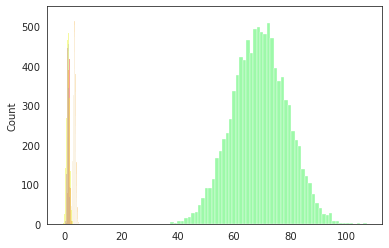

In [235]:
for i in range(k):
    sns.histplot(booted_tr[:, i, 8], alpha=0.5, color=svinet.colors[i+1])

In [238]:
props = {
    'boxprops': {'alpha': 0.5, 'edgecolor': 'k'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
meanprops = {
    "marker": "o",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": "6",
}

whisk = {
    5.0: [2.5, 97.5],
    1.0: [0.5, 99.5],
    0.1: [0.05, 99.95],
}
figs = []
sups = []
for ci, whisk_val in tqdm(whisk.items()):
    nrows = 2
    ncols = len(intervals)
    fig, axes = create_figure(nrows, ncols, (4 * ncols, 3.8 * nrows), 'ticks', 'col', False)

    for j, intvl in enumerate(intervals):
        dlist = []
        for i in range(k):
            dlist.append({
                'interval': [intervals[j]] * len(booted_tr),
                'oc_idx': [i + 1] * len(booted_tr),
                'mean': booted_tr[:, i, j],
            })
        _df = pd.DataFrame(merge_dicts(dlist))
        sns.histplot(
            data=_df,
            x='mean',
            hue='oc_idx',
            alpha=0.5,
            bins=100,
            palette=svinet.colors,
            ax=axes[0, j],
        )
        axes[0, j].set_title(f"bin: {intvl}\n", fontsize=15)

        sns.boxplot(
            data=_df,
            x='mean',
            y='oc_idx',
            palette=svinet.colors,
            dodge=True,
            orient='h',
            width=0.6,
            whis=whisk_val,
            # fliersize=1,
            showfliers=False,
            showmeans=True,
            meanprops=meanprops,
            ax=axes[1, j],
            **props,
        )
        for i in range(2):
            axes[i, j].grid(axis='both', ls=':')
            axes[i, j].axvline(0, color='dimgrey', lw=0.8, ls='--')
        if j == 0:
            axes[0, j].set_ylabel('kde (mice)\n', fontsize=15)
            axes[1, j].set_ylabel('box (mice)\n', fontsize=15)
        else:
            for i in range(2):
                axes[i, j].set_ylabel('')

    msg = f"Whiskers at {ci} % confidence interval: {whisk_val}"
    sup = fig.suptitle(msg, fontsize=20, y=1.07)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = [
    'hist-box-cox',
    # f"seeds-{'avg' if avg_seeds else 'single'}",
    f"bins-{len(intervals)}",
    f"boot-{n_boot:1.0e}",
]
save_file = f"{'_'.join(save_file)}.pdf"
save_file = pjoin(figs_dir, save_file)
print(save_file)
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')

  0%|          | 0/3 [00:00<?, ?it/s]

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6/hist-box-cox_bins-10_boot-1e+04.pdf

done.

In [239]:
sp_stats.skewtest(np.random.randn(10000000), axis=0, alternative='two-sided')

SkewtestResult(statistic=0.8494829800985998, pvalue=0.39561259684048355)

<AxesSubplot:ylabel='Count'>

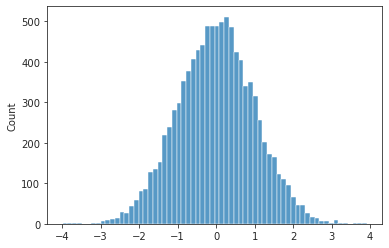

In [178]:
sns.histplot(np.random.randn(10000))

In [116]:
q = 1 - 0.05 / (6 * 10)
# q = 0.0001
t = abs(sp_stats.t.ppf(q, 9))

msg = f"p = {1-q:.3e},\t"
msg += r't^* = '
msg += f"{t}"
print(msg)

p = 8.333e-04,  t^* = 4.421869045738232

In [117]:

y = (x - se * t, x + se * t)

In [118]:
y

(
    array([[12.68158925,  9.58667519,  6.23181683,  4.88122532,  4.07314715,
         2.60034359,  2.45846198,  1.88409676,  1.02910255, 21.3004755 ],
       [ 4.79438566,  6.24373335,  4.73351603,  4.56272958,  5.14277751,
         3.30581978,  3.98965109,  3.781742  ,  3.38194733, 16.79442752],
       [ 1.58089219,  1.63087509,  2.49796596,  4.3340363 ,  5.34767691,
         5.9689988 ,  6.94660226,  8.39963724, 10.13168999, 14.93265432],
       [11.15610129, 10.40011175,  7.40418798,  6.15835886,  5.21565389,
         3.6725835 ,  3.16467797,  1.79078651,  1.25026086, 14.20674959],
       [17.66798882, 11.07231076,  6.78264691,  4.17166752,  3.48339172,
         1.60139509,  1.87666784,  1.75398742,  1.19839986, 16.3720661 ],
       [13.23489713,  8.95468453,  6.72535362,  5.35283407,  4.33460537,
         2.04301932,  0.91294168,  0.6420755 , -1.22112785, 16.5965676 ]]),
    array([[23.36754392, 15.52336209, 10.81964336,  8.56190213,  7.64149664,
         5.81770448,  5.89840403,  6.18736193,  5.40838609, 33.39175014],
       [16.73946031, 11.16538979,  9.46316955,  9.52446355,  9.03914565,
         8.26497982,  8.83247985,  8.93805086,  9.13982335, 39.04774947],
       [ 5.72550997,  7.09349202,  8.29098025,  8.56790494,  9.30665452,
         9.1463453 , 10.95898322, 13.76612818, 16.54560736, 32.87601958],
       [22.73071753, 15.31452436, 11.68360138,  9.44588018,  8.45954585,
         7.43239916,  7.19623522,  6.97108845,  6.10938477, 26.79567218],
       [29.1219666 , 16.63844386, 10.05269272,  7.37919154,  5.4395747 ,
         4.23357453,  3.79040226,  2.98772553,  2.66855936, 39.90532629],
       [30.50061834, 18.38062715, 11.57091593,  7.93062268,  6.74465467,
         6.43833372,  6.95077975,  6.56931958,  6.68182911, 24.84894558]])
)

In [119]:
x

array([[18.02456658, 12.55501864,  8.5257301 ,  6.72156372,  5.8573219 ,
         4.20902403,  4.178433  ,  4.03572934,  3.21874432, 27.34611282],
       [10.76692299,  8.70456157,  7.09834279,  7.04359656,  7.09096158,
         5.7853998 ,  6.41106547,  6.35989643,  6.26088534, 27.92108849],
       [ 3.65320108,  4.36218355,  5.3944731 ,  6.45097062,  7.32716572,
         7.55767205,  8.95279274, 11.08288271, 13.33864867, 23.90433695],
       [16.94340941, 12.85731805,  9.54389468,  7.80211952,  6.83759987,
         5.55249133,  5.18045659,  4.38093748,  3.67982281, 20.50121088],
       [23.39497771, 13.85537731,  8.41766982,  5.77542953,  4.46148321,
         2.91748481,  2.83353505,  2.37085648,  1.93347961, 28.13869619],
       [21.86775773, 13.66765584,  9.14813477,  6.64172837,  5.53963002,
         4.24067652,  3.93186071,  3.60569754,  2.73035063, 20.72275659]])

In [257]:
props = {
    'boxprops': {'alpha': 0.5, 'edgecolor': 'k'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
meanprops = {
    "marker": "o",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": "6",
}

whisk = {
    5.0: [2.5, 97.5],
    1.0: [0.5, 99.5],
    0.1: [0.05, 99.95],
    0.0: [0.0, 100.0],
}
figs = []
sups = []
for ci, whisk_val in tqdm(whisk.items()):
    nrows = 2
    ncols = len(intervals)
    fig, axes = create_figure(nrows, ncols, (4 * ncols, 3.8 * nrows), 'ticks', 'col', False)

    for j, intvl in enumerate(intervals):
        dlist = []
        for i in range(k):
            dlist.append({
                'interval': [intervals[j]] * len(booted),
                'oc_idx': [i + 1] * len(booted),
                'mean': booted[:, i, j].astype(float),
            })
        _df = pd.DataFrame(merge_dicts(dlist))
        sns.kdeplot(
            data=_df,
            x='mean',
            hue='oc_idx',
            cumulative=False,
            fill=True,
            alpha=0.05,
            lw=2,
            palette=svinet.colors,
            ax=axes[0, j],
        )
        axes[0, j].set_title(f"bin: {intvl}\n", fontsize=15)

        sns.boxplot(
            data=_df,
            x='mean',
            y='oc_idx',
            palette=svinet.colors,
            dodge=True,
            orient='h',
            width=0.6,
            whis=whisk_val,
            # fliersize=1,
            showfliers=False,
            showmeans=True,
            meanprops=meanprops,
            ax=axes[1, j],
            **props,
        )
        for i in range(2):
            axes[i, j].grid(axis='both', ls=':')
            axes[i, j].axvline(0, color='dimgrey', lw=0.8, ls='--')
        if j == 0:
            axes[0, j].set_ylabel('kde (mice)\n', fontsize=15)
            axes[1, j].set_ylabel('box (mice)\n', fontsize=15)
        else:
            for i in range(2):
                axes[i, j].set_ylabel('')

    msg = f"Whiskers at {ci} % confidence interval: {whisk_val}"
    sup = fig.suptitle(msg, fontsize=20, y=1.07)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = [
    'kde',
    # f"seeds-{'avg' if avg_seeds else 'single'}",
    f"bins-{len(intervals)}",
    f"boot-{n_boot:1.0e}",
]
save_file = f"{'_'.join(save_file)}.pdf"
save_file = pjoin(figs_dir, save_file)
print(save_file)
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')

  0%|          | 0/4 [00:00<?, ?it/s]

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6/kde_bins-10_boot-1e+04.pdf

done.

In [256]:
props = {
    'boxprops': {'alpha': 0.5, 'edgecolor': 'k'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
meanprops = {
    "marker": "o",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": "6",
}

whisk = {
    5.0: [2.5, 97.5],
    1.0: [0.5, 99.5],
    0.1: [0.05, 99.95],
}
figs = []
sups = []
for ci, whisk_val in tqdm(whisk.items()):
    nrows = 2
    ncols = len(intervals)
    fig, axes = create_figure(nrows, ncols, (4 * ncols, 3.8 * nrows), 'ticks', 'col', False)

    for j, intvl in enumerate(intervals):
        dlist = []
        for i in range(k):
            dlist.append({
                'interval': [intervals[j]] * len(booted),
                'oc_idx': [i + 1] * len(booted),
                'mean': booted[:, i, j].astype(float),
            })
        _df = pd.DataFrame(merge_dicts(dlist))
        sns.kdeplot(
            data=_df,
            x='mean',
            hue='oc_idx',
            cumulative=True,
            fill=True,
            alpha=0.05,
            lw=2,
            palette=svinet.colors,
            ax=axes[0, j],
        )
        axes[0, j].set_title(f"bin: {intvl}\n", fontsize=15)

        sns.boxplot(
            data=_df,
            x='mean',
            y='oc_idx',
            palette=svinet.colors,
            dodge=True,
            orient='h',
            width=0.6,
            whis=whisk_val,
            # fliersize=1,
            showfliers=False,
            showmeans=True,
            meanprops=meanprops,
            ax=axes[1, j],
            **props,
        )
        for i in range(2):
            axes[i, j].grid(axis='both', ls=':')
            axes[i, j].axvline(0, color='dimgrey', lw=0.8, ls='--')
        if j == 0:
            axes[0, j].set_ylabel('kde (mice)\n', fontsize=15)
            axes[1, j].set_ylabel('box (mice)\n', fontsize=15)
        else:
            for i in range(2):
                axes[i, j].set_ylabel('')

    msg = f"Whiskers at {ci} % confidence interval: {whisk_val}"
    sup = fig.suptitle(msg, fontsize=20, y=1.07)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = [
    'kde-cdf',
    # f"seeds-{'avg' if avg_seeds else 'single'}",
    f"bins-{len(intervals)}",
    f"boot-{n_boot:1.0e}",
]
save_file = f"{'_'.join(save_file)}.pdf"
save_file = pjoin(figs_dir, save_file)
print(save_file)
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')

  0%|          | 0/3 [00:00<?, ?it/s]

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6/kde-cdf_bins-10_boot-1e+04.pdf

done.

## Fitter

In [293]:
def best_fit_distribution(data, distn_names, bins=500):
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    best_dists = {}
    for ii, dist in enumerate([d for d in distn_names if d not in ['levy_stable', 'studentized_range']]):
        print("{:>3} / {:<3}: {}".format(ii + 1, len(distn_names), dist))
        dist_fn = getattr(sp_stats, dist)
        params = dist_fn.fit(data)
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
        pdf = dist_fn.pdf(x, loc=loc, scale=scale, *arg)
        sse = np.sum(np.power(y - pdf, 2.0))
        best_dists[dist] = (dist_fn, params, sse)
    best_dists = dict(sorted(best_dists.items(), key=lambda e: e[1][2]))
    return best_dists

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.001, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.001, loc=loc, scale=scale)
    end = dist.ppf(0.999, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.999, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [294]:
distn_names = [
    'alpha', 'beta',
    'gamma', 'lognorm',
    'weibull_min', 'weibull_max',
    't', 'chi2',
]
best_distibutions = best_fit_distribution(
    data=booted[:, max_ids[0], max_ids[1]].astype(float),
    distn_names=distn_names,
    bins=500,
)

1 / 8  : alpha

2 / 8  : beta

3 / 8  : gamma

4 / 8  : lognorm

5 / 8  : weibull_min

6 / 8  : weibull_max

7 / 8  : t

8 / 8  : chi2

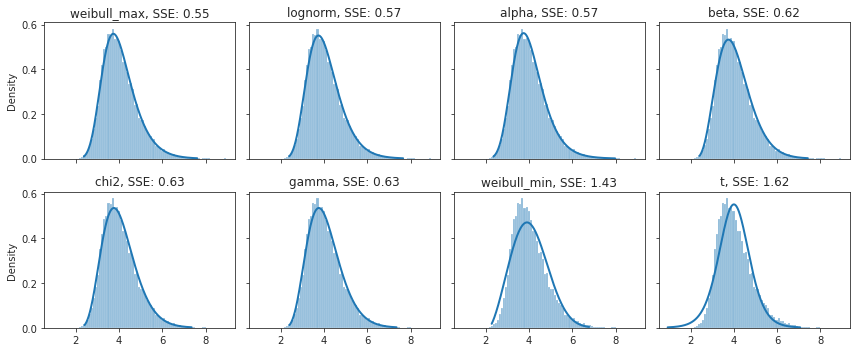

In [297]:
fig, axes = create_figure(2, 4, (12, 5), 'ticks', 'all', 'all')

for ax, (k, v) in zip(axes.ravel(), best_distibutions.items()):
    pdf = make_pdf(v[0], v[1], size=1000)
    ax.plot(list(pdf.index), list(pdf.values), lw=2)
    sns.histplot(booted[:, max_ids[0], max_ids[1]].astype(float), stat='density', alpha=0.5, ax=ax)
    ax.set_title(f"{k}, SSE: {v[2]:.2f}")
plt.show()

In [298]:
best_distibutions2 = best_fit_distribution(
    data=booted[:, min_ids[0], min_ids[1]].astype(float),
    distn_names=distn_names,
    bins=500,
)

1 / 8  : alpha

2 / 8  : beta

3 / 8  : gamma

4 / 8  : lognorm

5 / 8  : weibull_min

6 / 8  : weibull_max

7 / 8  : t

8 / 8  : chi2

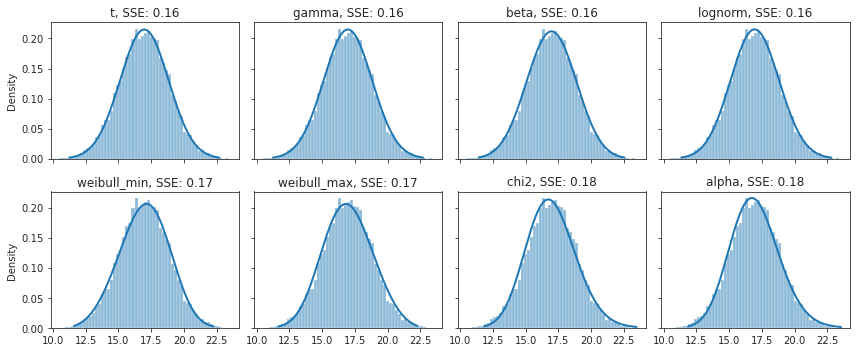

In [299]:
fig, axes = create_figure(2, 4, (12, 5), 'ticks', 'all', 'all')

for ax, (k, v) in zip(axes.ravel(), best_distibutions2.items()):
    pdf = make_pdf(v[0], v[1], size=1000)
    ax.plot(list(pdf.index), list(pdf.values), lw=2)
    sns.histplot(booted[:, min_ids[0], min_ids[1]].astype(float), stat='density', alpha=0.5, ax=ax)
    ax.set_title(f"{k}, SSE: {v[2]:.2f}")
plt.show()

In [302]:
i, j = np.unravel_index(np.argmin(skew), skew.shape)
skew[i, j]

-18.843772460712728

-18.843772460712728

In [303]:
i, j = np.unravel_index(np.argmin(skew), skew.shape)

best_distibutions2 = best_fit_distribution(
    data=booted[:, i, j].astype(float),
    distn_names=distn_names,
    bins=500,
)

1 / 8  : alpha

2 / 8  : beta

3 / 8  : gamma

4 / 8  : lognorm

5 / 8  : weibull_min

6 / 8  : weibull_max

7 / 8  : t

8 / 8  : chi2

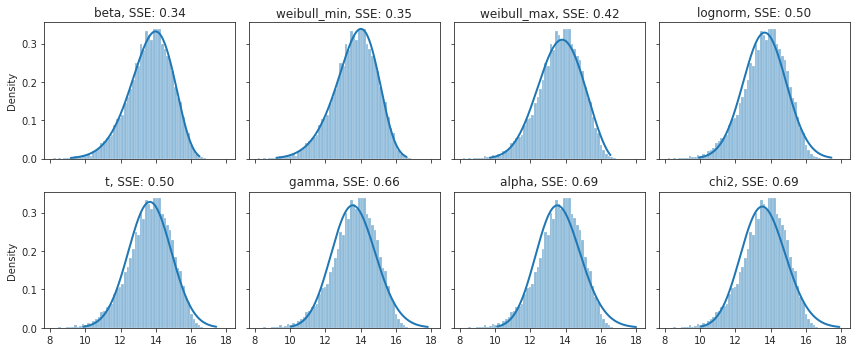

In [304]:
fig, axes = create_figure(2, 4, (12, 5), 'ticks', 'all', 'all')

for ax, (k, v) in zip(axes.ravel(), best_distibutions2.items()):
    pdf = make_pdf(v[0], v[1], size=1000)
    ax.plot(list(pdf.index), list(pdf.values), lw=2)
    sns.histplot(booted[:, i, j].astype(float), stat='density', alpha=0.5, ax=ax)
    ax.set_title(f"{k}, SSE: {v[2]:.2f}")
plt.show()

In [334]:
booted_log = np.log(booted)

<AxesSubplot:ylabel='Density'>

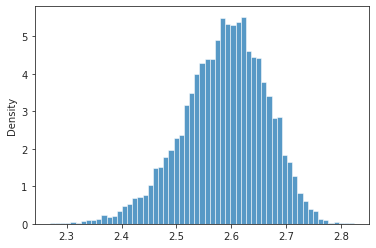

In [335]:
sns.histplot(booted_log[:, 2, 8], stat='density')

<AxesSubplot:ylabel='Density'>

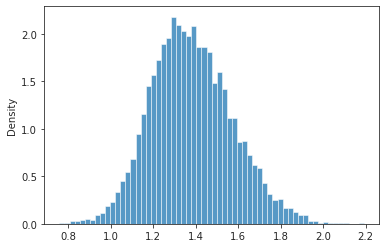

In [336]:
sns.histplot(booted_log[:, max_ids[0], max_ids[1]], stat='density')

<AxesSubplot:ylabel='Density'>

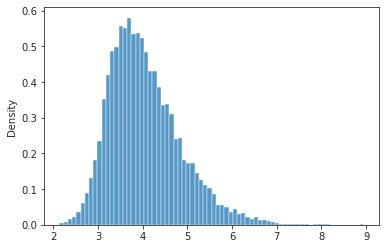

In [337]:
sns.histplot(booted[:, max_ids[0], max_ids[1]], stat='density')

In [339]:
np.log(100)

4.605170185988092

In [342]:
skew_before = sp_stats.skew(booted.astype(float))
skew_after = sp_stats.skew(booted_log.astype(float))

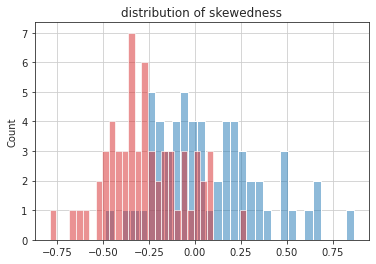

In [343]:
sns.histplot(skew_before.ravel(), bins=30, color='C0', alpha=0.5)
sns.histplot(skew_after.ravel(), bins=30, color='C3', alpha=0.5)
plt.title('distribution of skewedness')
plt.grid()

In [344]:
from sklearn.preprocessing import QuantileTransformer

In [353]:
qt = QuantileTransformer(
    output_distribution='normal',
    n_quantiles=1000,
    random_state=0,
)
booted_tr = qt.fit_transform(booted.reshape(len(booted), -1))
booted_tr = booted_tr.reshape(booted.shape)

<AxesSubplot:ylabel='Count'>

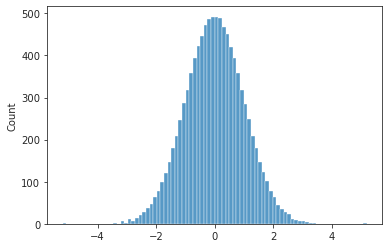

In [354]:
sns.histplot(booted_tr[:, i, j])

<AxesSubplot:ylabel='Count'>

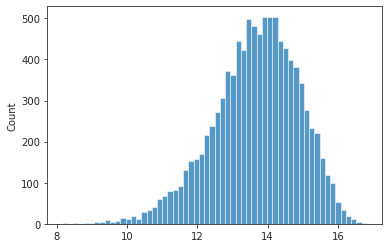

In [355]:
sns.histplot(booted[:, i, j])

In [357]:
real_data_tr = qt.transform(real_data.reshape(1, -1))
real_data_tr = real_data_tr.reshape(real_data.shape)

In [358]:
real_data_tr

array([[-0.0238522 , -0.02979814, -0.0065471 , -0.05142252,  0.00594194,
         0.02241137,  0.07468113,  0.14073878,  0.08635596,  0.03220681],
       [ 0.06501133,  0.05398794, -0.0082951 , -0.04919765, -0.01457294,
        -0.0071343 , -0.0154272 ,  0.03513785,  0.03553733,  0.0451455 ],
       [ 0.05542866,  0.01612663, -0.00214004,  0.02507929, -0.05226562,
         0.01051006, -0.04861821, -0.00594663, -0.02072443,  0.06063239],
       [-0.02143672, -0.00788592, -0.00885013, -0.05847402, -0.06753839,
        -0.00962229,  0.05049708,  0.09394314,  0.09911161,  0.06037793],
       [ 0.05823311, -0.05222858, -0.00242084, -0.04946151, -0.04311003,
        -0.08525942, -0.01533527,  0.18007227, -0.10430058,  0.02652341],
       [-0.05422126, -0.06572383, -0.08183949, -0.08958072,  0.00382831,
         0.10244938,  0.06835919,  0.11996616,  0.11988117,  0.05912278]])

In [359]:
real_data

array([[18.02456658, 12.55501864,  8.5257301 ,  6.72156372,  5.8573219 ,
         4.20902403,  4.178433  ,  4.03572934,  3.21874432, 27.34611282],
       [10.76692299,  8.70456157,  7.09834279,  7.04359656,  7.09096158,
         5.7853998 ,  6.41106547,  6.35989643,  6.26088534, 27.92108849],
       [ 3.65320108,  4.36218355,  5.3944731 ,  6.45097062,  7.32716572,
         7.55767205,  8.95279274, 11.08288271, 13.33864867, 23.90433695],
       [16.94340941, 12.85731805,  9.54389468,  7.80211952,  6.83759987,
         5.55249133,  5.18045659,  4.38093748,  3.67982281, 20.50121088],
       [23.39497771, 13.85537731,  8.41766982,  5.77542953,  4.46148321,
         2.91748481,  2.83353505,  2.37085648,  1.93347961, 28.13869619],
       [21.86775773, 13.66765584,  9.14813477,  6.64172837,  5.53963002,
         4.24067652,  3.93186071,  3.60569754,  2.73035063, 20.72275659]])

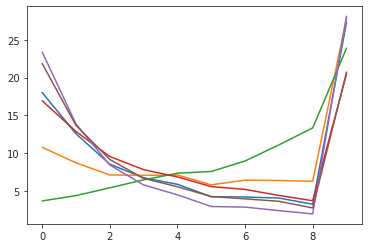

In [361]:
plt.plot(real_data.T);

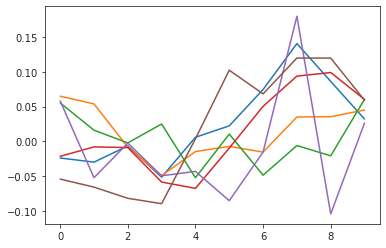

In [362]:
plt.plot(real_data_tr.T);

In [48]:
from fitter import Fitter

distn_names = [
    't',
    'beta',
    'gamma',
    'lognorm',
    'norm',
]
fitted = {}
for i in tqdm(range(k)):
    f = Fitter(
        data=booted[:, i, -2].astype(float),
        distributions=distn_names,
        bins=200,
        timeout=1000,
    )
    f.fit(progress=False)
    fitted[i] = f

  0%|          | 0/6 [00:00<?, ?it/s]

,sumsquare_error,aic,bic,kl_div
beta,0.498434,868.530114,-99029.409362,inf
lognorm,0.521987,825.016039,-98576.894332,inf
gamma,0.522544,821.963150,-98566.229416,inf
t,0.527225,820.575053,-98477.044567,inf
norm,0.527229,818.566805,-98486.189464,inf


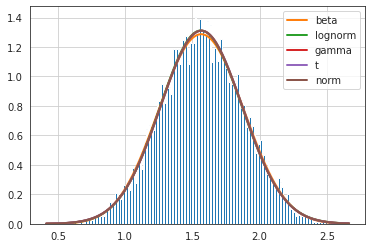

In [59]:
fitted[4].summary()

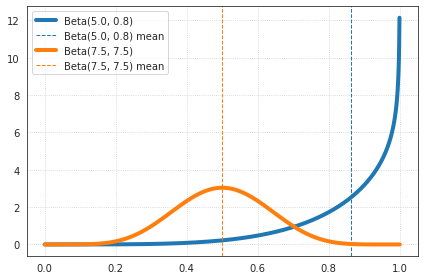

In [33]:
fig, ax = create_figure(1, 1)

x = np.linspace(0, 1, 1000)

a, b = 5., 0.8
ax.plot(x, sp_stats.beta.pdf(x, a, b),
        color='C0', lw=4, label=f"Beta({a:.1f}, {b:.1f})")
ax.axvline(a / (a + b), color='C0', lw=1, ls='--', label=f"Beta({a:.1f}, {b:.1f}) mean")

a, b = 7.5, 7.5
ax.plot(x, sp_stats.beta.pdf(x, a, b),
        color='C1', lw=4, label=f"Beta({a:.1f}, {b:.1f})")
ax.axvline(a / (a + b), color='C1', lw=1, ls='--', label=f"Beta({a:.1f}, {b:.1f}) mean")

ax.grid(ls=':')
ax.legend()
plt.show()

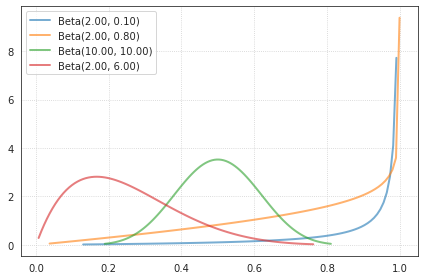

In [7]:
fig, ax = create_figure(1, 1)

a, b = 2., 0.1
x = np.linspace(sp_stats.beta.ppf(0.001, a, b),
                sp_stats.beta.ppf(0.999, a, b), 100)
ax.plot(x, sp_stats.beta.pdf(x, a, b),
       color='C0', lw=2, alpha=0.6, label=f"Beta({a:.2f}, {b:.2f})")

a, b = 2., 0.8
x = np.linspace(sp_stats.beta.ppf(0.001, a, b),
                sp_stats.beta.ppf(0.999, a, b), 100)
ax.plot(x, sp_stats.beta.pdf(x, a, b),
       color='C1', lw=2, alpha=0.6, label=f"Beta({a:.2f}, {b:.2f})")

a, b = 10., 10.
x = np.linspace(sp_stats.beta.ppf(0.001, a, b),
                sp_stats.beta.ppf(0.999, a, b), 100)
ax.plot(x, sp_stats.beta.pdf(x, a, b),
       color='C2', lw=2, alpha=0.6, label=f"Beta({a:.2f}, {b:.2f})")

a, b = 2., 6
x = np.linspace(sp_stats.beta.ppf(0.001, a, b),
                sp_stats.beta.ppf(0.999, a, b), 100)
ax.plot(x, sp_stats.beta.pdf(x, a, b),
       color='C3', lw=2, alpha=0.6, label=f"Beta({a:.2f}, {b:.2f})")
ax.grid(ls=':')
ax.legend()
plt.show()

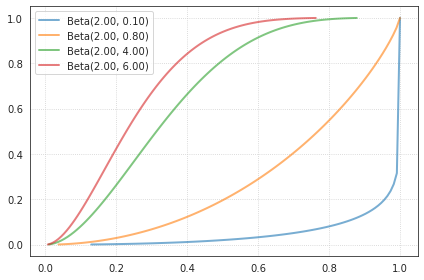

In [389]:
fig, ax = create_figure(1, 1)

a, b = 2., 0.1
x = np.linspace(sp_stats.beta.ppf(0.001, a, b),
                sp_stats.beta.ppf(0.999, a, b), 100)
ax.plot(x, sp_stats.beta.cdf(x, a, b),
       color='C0', lw=2, alpha=0.6, label=f"Beta({a:.2f}, {b:.2f})")

a, b = 2., 0.8
x = np.linspace(sp_stats.beta.ppf(0.001, a, b),
                sp_stats.beta.ppf(0.999, a, b), 100)
ax.plot(x, sp_stats.beta.cdf(x, a, b),
       color='C1', lw=2, alpha=0.6, label=f"Beta({a:.2f}, {b:.2f})")

a, b = 2., 4
x = np.linspace(sp_stats.beta.ppf(0.001, a, b),
                sp_stats.beta.ppf(0.999, a, b), 100)
ax.plot(x, sp_stats.beta.cdf(x, a, b),
       color='C2', lw=2, alpha=0.6, label=f"Beta({a:.2f}, {b:.2f})")

a, b = 2., 6
x = np.linspace(sp_stats.beta.ppf(0.001, a, b),
                sp_stats.beta.ppf(0.999, a, b), 100)
ax.plot(x, sp_stats.beta.cdf(x, a, b),
       color='C3', lw=2, alpha=0.6, label=f"Beta({a:.2f}, {b:.2f})")
ax.grid(ls=':')
ax.legend()
plt.show()

In [390]:
data_all.shape

(10, 3, 835, 6, 10)

In [391]:
x = np.median(data_all, axis=2)
x.shape

(10, 3, 6, 10)

In [395]:
for key, g in result['gamma_all'].items():
    g

In [403]:
pi = g / g.sum(0, keepdims=True)

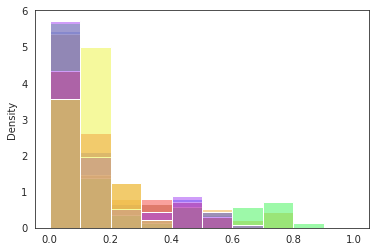

In [407]:
for i in range(k):
    x = result['pi'][i].copy()
    sns.histplot(x[x > 0],
                 color=svinet.colors[i+1],
                 bins=np.linspace(0, 1, 11),
                 alpha=0.5,
                 stat='density',
                )

## New, correct Fig

In [ ]:
real_sample = np.median(data_all, axis=2).mean(1, dtype='float128')

real_sample.shape, booted.shape, data_all.shape

In [ ]:
dlist1, dlist2 = [], []
for i in range(k):
    for j, intvl in enumerate(intervals):
        dlist1.append({
            'condition': ['real'] * len(real_sample),
            'interval': [intvl] * len(real_sample),
            'oc_idx': [i + 1] * len(real_sample),
            'mean': real_sample[:, i, j],
        })
        dlist2.append({
            'condition': ['boot'] * len(booted),
            'interval': [intvl] * len(booted),
            'oc_idx': [i + 1] * len(booted),
            'mean': booted[:, i, j],
        })
df_real = pd.DataFrame(merge_dicts(dlist1))
df_boot = pd.DataFrame(merge_dicts(dlist2))

In [ ]:
df_real.shape, df_boot.shape

In [ ]:
props_boot = {
    'boxprops': {'color': 'none', 'edgecolor': 'k', 'linewidth': 1},
    'medianprops': {'color': 'none', 'linewidth': 0},
    'whiskerprops': {'color': 'k', 'linewidth': 1},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
props_real = {
    'boxprops': {'color': 'none', 'edgecolor': 'none', 'linewidth': 0},
    'medianprops': {'color': 'k', 'linewidth': 1.5},
    'whiskerprops': {'color': 'none', 'linewidth': 0},
    'capprops': {'color': 'none', 'linewidth': 0},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}
meanprops = {
    "marker": "X",
    "markerfacecolor": "bisque",
    "markeredgecolor": "k",
    "markersize": "8",
}

figs, sups = [], []
cis = [100, 99.9, 99.0, 95.0][::-1]
for ci in tqdm(cis):
    lower = np.round((100 - ci) / 2, 3)
    higher = np.round(100 - (100 - ci) / 2, 3)
    
    nrows = 2
    ncols = int(np.ceil(k / nrows))
    fig, axes = create_figure(
        nrows=nrows,
        ncols=ncols,
        figsize=(13.5, 11),
        style='ticks',
        sharex='all',
        sharey='all',
        reshape=True,
    )

    for ax, oc_idx in zip(axes.ravel(), range(1, k + 1)):
        _df = df_boot.loc[df_boot.oc_idx == oc_idx]
        sns.boxplot(
            data=_df,
            x='interval',
            y='mean',
            palette='turbo',
            whis=[lower, higher],
            showfliers=False,
            ax=ax,
            **props_boot,
        )

        _df = df_real.loc[df_real.oc_idx == oc_idx]
        sns.stripplot(
            x='interval',
            y='mean',
            data=_df,
            palette='turbo',
            size=6,
            alpha=0.5,
            linewidth=0.0,
            ax=ax,
        )
        sns.boxplot(
            data=_df,
            x='interval',
            y='mean',
            palette='turbo',
            showfliers=False,
            showmeans=True,
            meanprops=meanprops,
            ax=ax,
            **props_real,
        )
        ax.axhline(0, color='dimgrey', lw=0.8, ls='--')
        ax.grid(ls=':')
        ax.tick_params(axis='x', rotation=-90)
        ax.set_title(f"OC{oc_idx}", fontsize=13)
        if (oc_idx - 1) % ncols == 0:
            ax.set_ylabel('mean percentage', fontsize=13)
        else:
            ax.set_ylabel('')
    _ = trim_axs(axes, k)
    msg = f"ci = {ci} % whiskers: [{lower}, {higher}]\n"
    msg += "median, mean and scatter points: 'actual' sample\nwhiskers, caps: 'bootstrapped' samples"
    sup = fig.suptitle(msg, fontsize=17, y=1.05)
    figs.append(fig)
    sups.append(sup)
    plt.close()

save_file = [
    'group',
    # f"seeds-{'avg' if avg_seeds else 'single'}",
    f"bins-{len(intervals)}",
    f"boot-{n_boot:1.0e}",
]
save_file = f"{'_'.join(save_file)}.pdf"
save_file = pjoin(figs_dir, save_file)
print(save_file)
save_fig(
    fig=figs,
    sup=sups,
    save_file=save_file,
    display=False,
    multi=True,
)
print('done.')